In [1]:
import fasttreeshap
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pyCompare
import re
import seaborn as sns
import shap
import skill_metrics as skm
import statsmodels.api as sm
import eli5

from dominance_analysis import Dominance
from eli5.sklearn import PermutationImportance
from itertools import combinations
from matplotlib import rc
from patsy import dmatrices
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.mstats import zscore
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score,max_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import maxabs, mse, rmse, bias
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.model_selection import CVScores

sns.set(rc={'figure.figsize':(15,8)})
sns.color_palette("Spectral")

sns.set_context("paper")
sns.set_style("white")


plt.rc('legend',fontsize=14)


float_format='{:.2f}'.format
pd.options.display.float_format = '{:.2f}'.format


AQS = ['AQ1', 'AQ2']
POLLUTANTS = ['O3', 'NO2']

PRETTYNAMES = {'aq_NO2': 'NO2', 'aq_O3': 'O3', 
               'aq_RH': 'RH',
               'horiba_NO2': 'Horiba NO2', 'horiba_O3': 'Horiba O3', 
               'aq_extT': 'extT', 'aq_intT': 'intT'}

FIGURES=["a","b","c","d"]

/home/alice/.local/lib/python3.7/site-packages/ecmwflibs/__init__.py:139: UserWarning:

ecmwflibs universal: found eccodes at libeccodes.so.0



Loading BokehJS ...

In [2]:
def merge_images(images, x, y, output, legends=[], ratio=1):

    f, axarr = plt.subplots(y, x, figsize=(14, 14*ratio))
    count = 0
    for i in range(x):
        for j in range(y):
            if x == 1:
                axarr[j].imshow(mpimg.imread(images[count]))
            elif y == 1:
                axarr[i].imshow(mpimg.imread(images[count]))
            else:
                axarr[j,i].imshow(mpimg.imread(images[count]))
            os.remove(images[count])
            count += 1
        
    for i, legend in enumerate(legends):
        axarr[i,1].text(-0.05, 0, f'({FIGURES[i]})', transform=axarr[i,1].transAxes, size='x-large')

    # turn off x and y axis
    [ax.set_axis_off() for ax in axarr.ravel()]

    plt.tight_layout()
    plt.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

## Horiba read

In [3]:
horiba = pd.read_csv("datasets/HORIBA.csv", parse_dates=['date']).set_index(['date'])

## AQs read

In [4]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75],interpolation = 'midpoint')
    #print(Q1,Q3)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [5]:
airqino = {}

for aq in AQS:
    airqino[aq] = pd.read_csv(f"datasets/{aq}_calibration.csv", parse_dates=['date']).set_index(['date'])
    previous_len = len(airqino[aq])
    
    for pollutant in ["aq_NO2","aq_O3","aq_intT","aq_extT","aq_RH"]:
        pmin, pmax = outlier_treatment(airqino[aq][pollutant])
#        print(pollutantpmin, pmax)
        airqino[aq][pollutant]=airqino[aq][pollutant].mask(airqino[aq][pollutant] > pmax, np.NaN)
        airqino[aq][pollutant]=airqino[aq][pollutant].mask(airqino[aq][pollutant] < pmin, np.NaN)

    airqino[aq].aq_RH=airqino[aq].aq_RH.mask(airqino[aq].aq_RH > 99, np.NaN)
    airqino[aq]=airqino[aq].dropna()
    print(f"{aq} was {previous_len}, now is {len(airqino[aq])} = {round((previous_len - len(airqino[aq])) /previous_len *100)}% withdrawn")

AQ1 was 58949, now is 57890 = 2% withdrawn
AQ2 was 59261, now is 51868 = 12% withdrawn


# Calibration Union dataset


In [6]:
union = {}
for aq in AQS:
    union[aq]=pd.merge(horiba, airqino[aq], how='inner', left_index=True, right_index=True)


# EDA

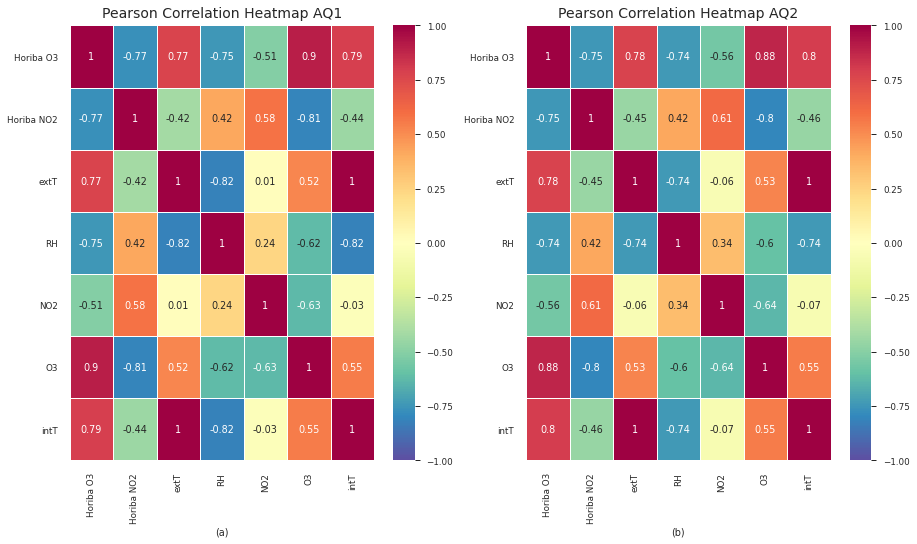

In [7]:
fig, ax =plt.subplots(1,2)

for i,aq in enumerate(AQS):
    corr=union[aq].corr().round(2)

    corr.rename(columns=PRETTYNAMES,
                index=PRETTYNAMES,inplace=True)

    mask = np.triu(np.ones_like(corr, dtype=bool))
    heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='Spectral_r',ax=ax[i])
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0)
    heatmap.set_title('Pearson Correlation Heatmap %s'%aq, fontdict={'fontsize':14}, pad=8);
    heatmap.set_xlabel("(%s)"%FIGURES[i])

plt.savefig(f"sup_s02_pearson.png", bbox_inches='tight', dpi=300)
plt.show()


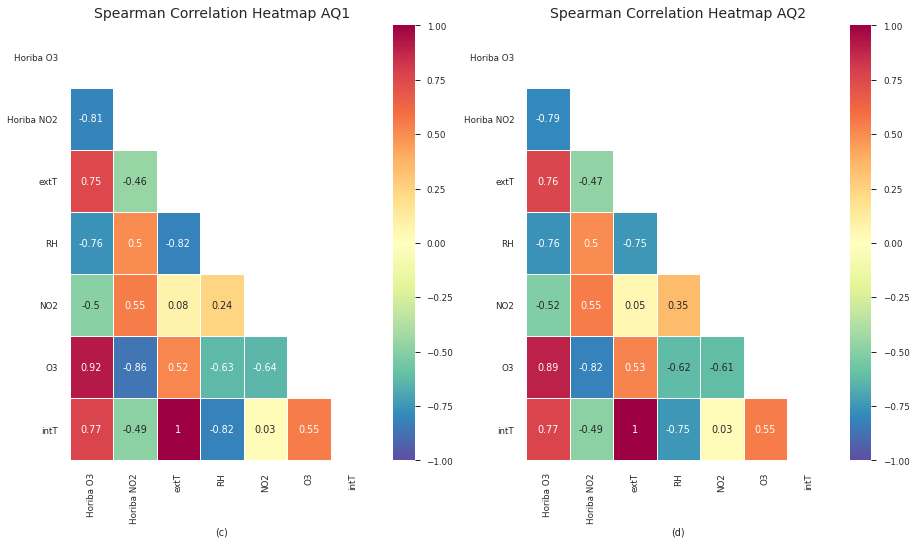

In [8]:
fig, ax =plt.subplots(1,2)

for i,aq in enumerate(AQS):
  
    corr_sp=union[aq].corr(method="spearman").round(2)

    corr_sp.rename(columns=PRETTYNAMES,
                index=PRETTYNAMES,inplace=True)

    mask = np.triu(np.ones_like(corr, dtype=bool))
    heatmap = sns.heatmap(corr_sp, mask=mask, vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='Spectral_r',ax=ax[i])
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0)
    heatmap.set_title('Spearman Correlation Heatmap %s'%aq, fontdict={'fontsize':14}, pad=8);
    heatmap.set_xlabel("(%s)"%FIGURES[i+2])

plt.savefig(f"sup_s02_spearman.png", bbox_inches='tight', dpi=300)
plt.show()

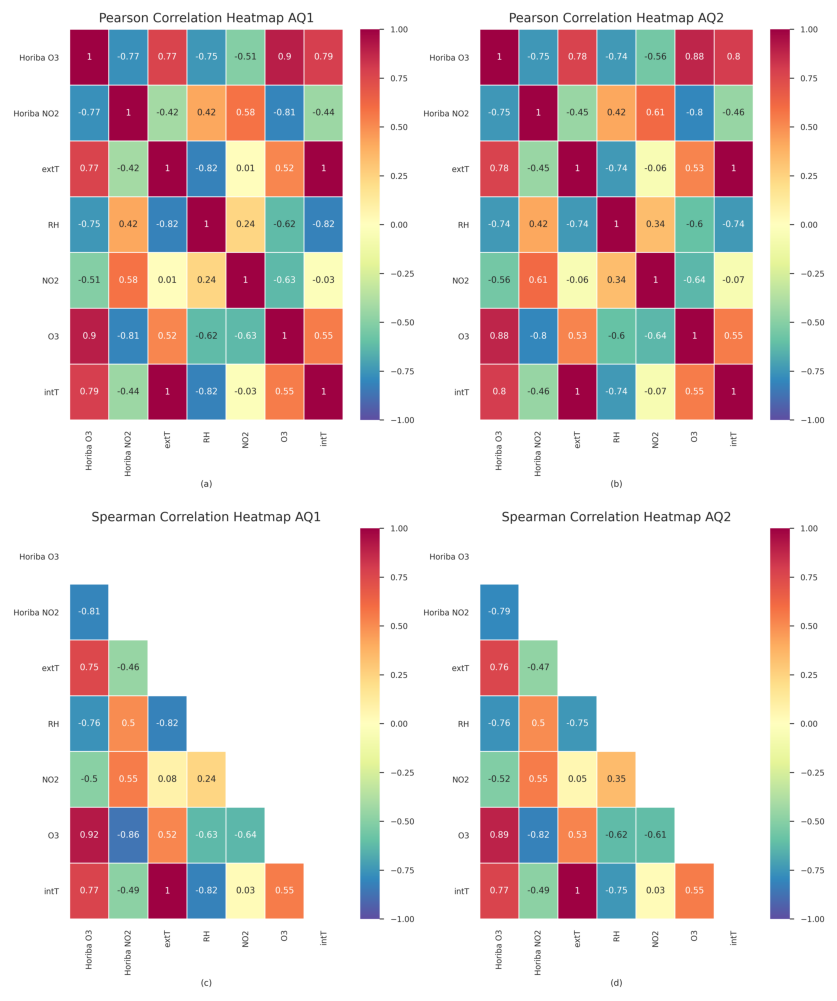

In [9]:
merge_images(["sup_s02_pearson.png", "sup_s02_spearman.png"], 1, 2, "figures/sup_s02.png")

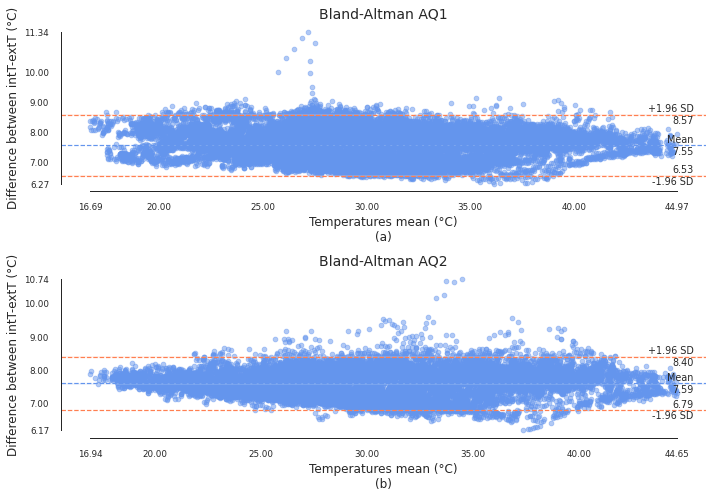

In [10]:
fig, ax =plt.subplots(2,1,figsize = (10,7))
for i, aq in enumerate(AQS):
    
    a = pyCompare.blandAltman(union[aq]["aq_intT"], union[aq]["aq_extT"], 
            confidenceInterval=95,
            confidenceIntervalMethod='approximate', ax=ax[i])
    a.set_ylabel("Difference between intT-extT (°C)",fontsize=12)
    a.set_xlabel("Temperatures mean (°C)\n(%s)"%FIGURES[i],fontsize=12)
    a.set_title("Bland-Altman %s"%(aq),fontsize=14)
fig.tight_layout()
plt.savefig(f"figures/sup_s03.png", dpi=300)
plt.show()

## K-Means

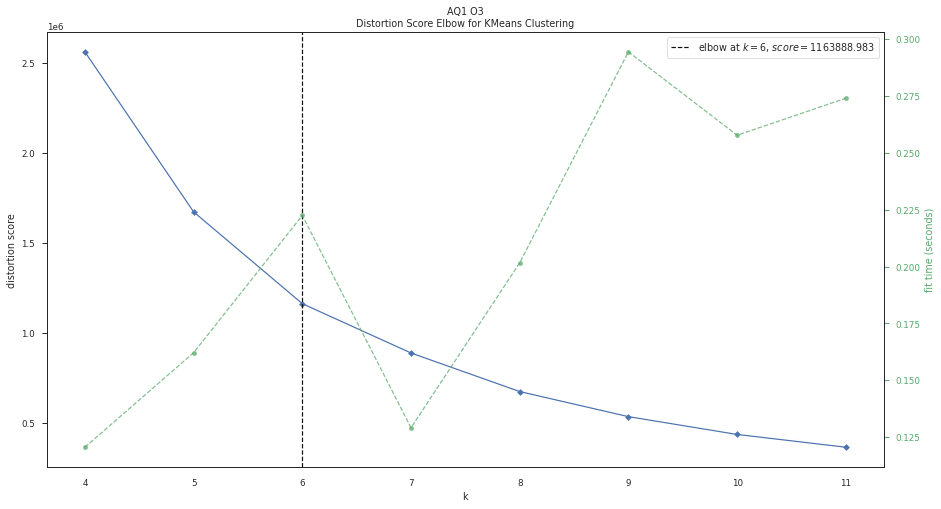

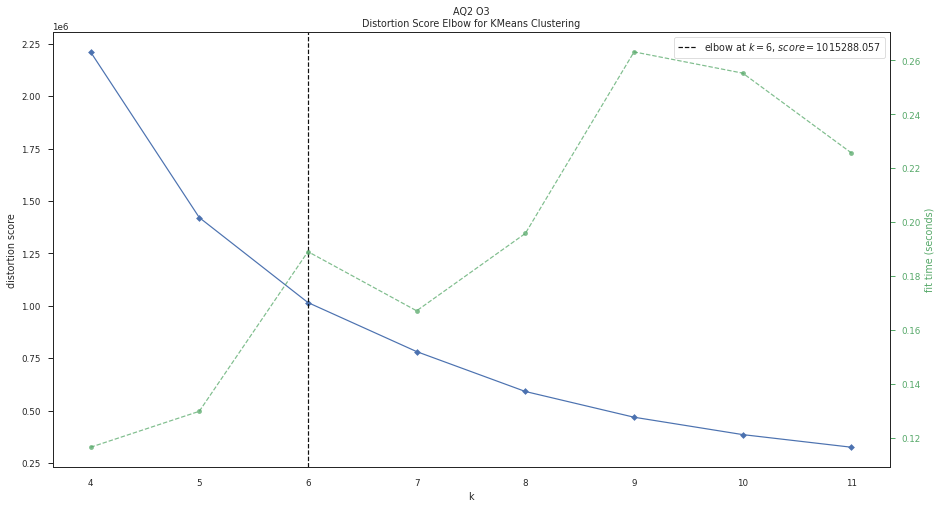

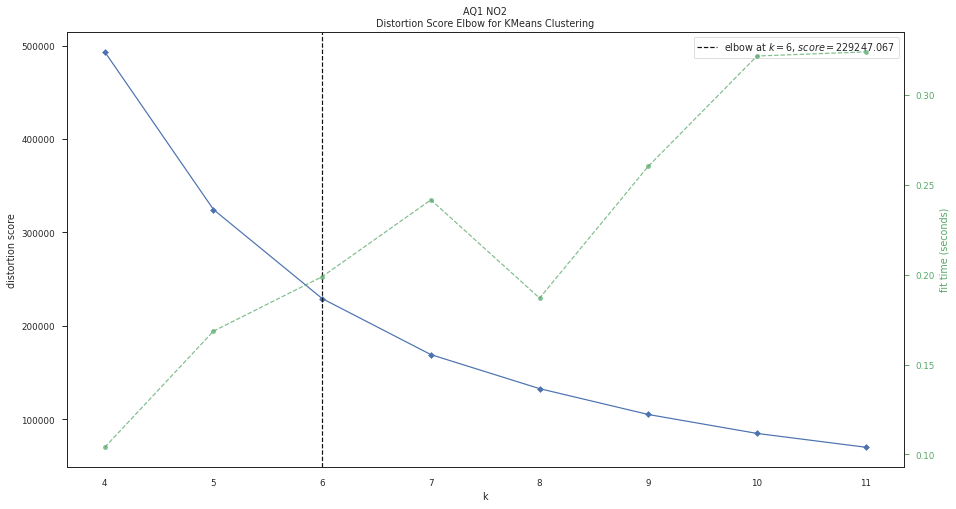

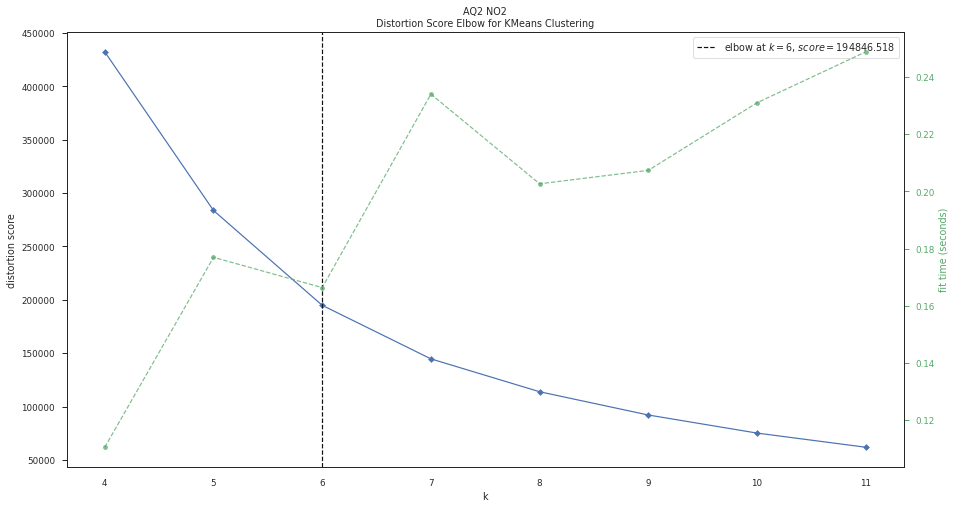

In [11]:
#elbow method
for pollutant in POLLUTANTS:
    for aq in AQS:
        kmeans_model = KMeans()
        visualizer = KElbowVisualizer(kmeans_model, k=(4,12))

        visualizer.fit(union[aq][["horiba_%s"%pollutant]])       
        best_clusters_number = visualizer.elbow_value_
        plt.title(f"{aq} {pollutant}\n")
        visualizer.show()

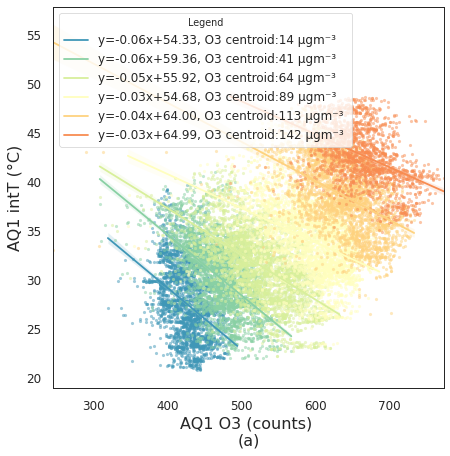

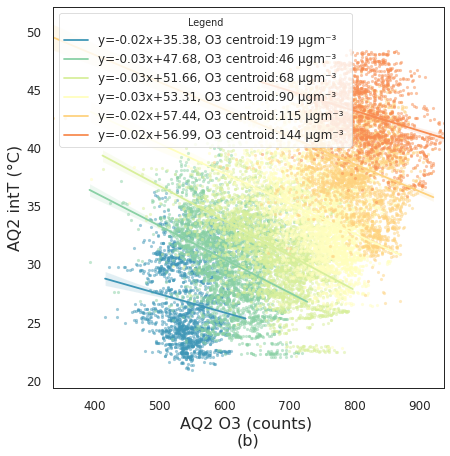

In [12]:
palette=sns.color_palette('Spectral_r', 7)

for pollutant in ["O3"]:
    for j, aq in enumerate(AQS):
        plt.figure(figsize=(7,7))

        kmeans = KMeans(n_clusters=best_clusters_number, init='k-means++',random_state=42).fit(union[aq][["horiba_%s"%pollutant]])

        kmeans_cluster_centers = kmeans.cluster_centers_
        union[aq]["cluster"] = kmeans.fit_predict(union[aq][["horiba_%s"%pollutant]])
        
        centroids = kmeans_cluster_centers
        union[aq]['centroid'] = union[aq].apply(lambda row: centroids[int(row['cluster'])][0], axis=1)
        gk = union[aq].groupby('centroid')
        
        labels=[]
        for i, (name, cluster) in enumerate(gk):

            y = cluster['aq_intT']
            X = cluster[f'aq_{pollutant}']

            X=sm.add_constant(X)
            rlm_model = sm.OLS(y,X)
            rlm_results = rlm_model.fit()
            
         
            slope=rlm_results.params[1]
            intercept=rlm_results.params[0]

            ax=sns.regplot(data=cluster, x=f'aq_{pollutant}', y='aq_intT', order=1,robust=False,truncate=True, scatter=True,
                           scatter_kws={'s': 10, 'alpha':0.5,'color':palette[i]},
                          line_kws={'color':palette[i]})
              

            labels.append(r"y={0:.2f}x{1:+.2f}, O3 centroid:{2:.0f} μgm⁻³ ".format(slope,intercept,name))
        plt.ylabel(f"{aq} intT (°C)",fontsize=16)
        plt.xlabel(f"{aq} {pollutant} (counts) \n({FIGURES[j]})",fontsize=16)
        plt.tick_params(axis="both", labelsize=12)
        plt.legend(labels, title="Legend",loc='upper left',frameon=True,fontsize=12)
            
        plt.savefig(f"fig04_{aq}_{pollutant}.png", bbox_inches='tight', dpi=300)
        plt.show()

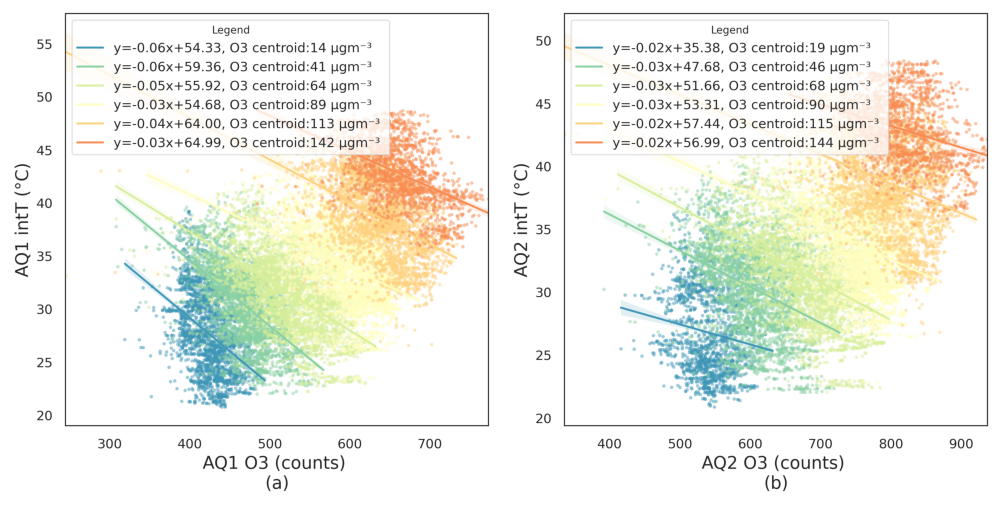

In [13]:
merge_images(["fig04_AQ1_O3.png", "fig04_AQ2_O3.png"], 2, 1, "figures/fig04.png")

## Jointplot calibration dataset

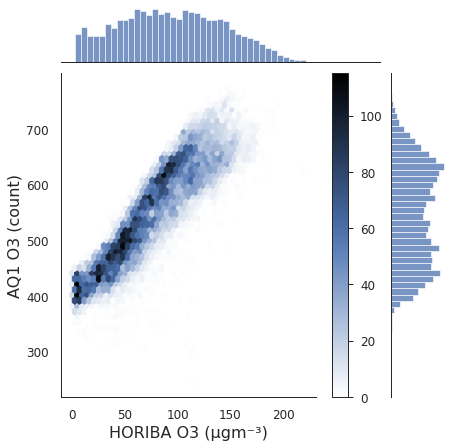

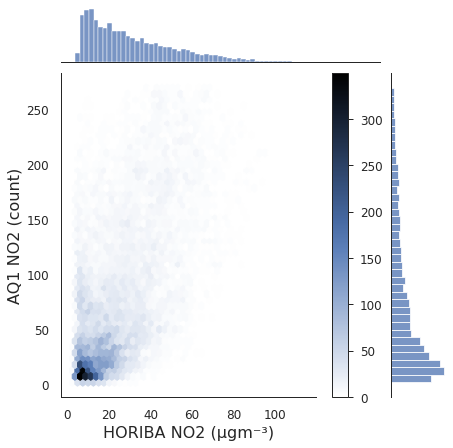

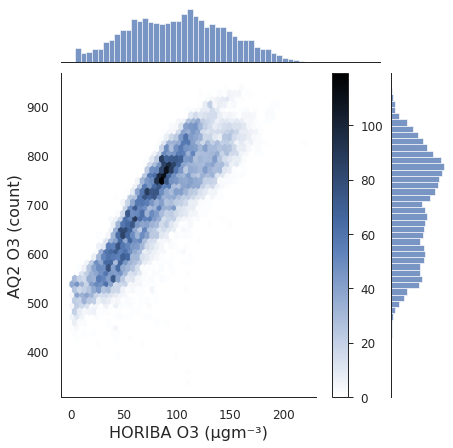

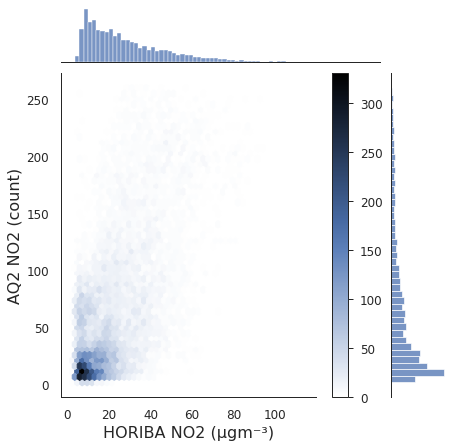

In [14]:
count = 0
for i, aq in enumerate(AQS):
    g = sns.jointplot(x=union[aq]["horiba_O3"].values, y=union[aq]["aq_O3"].values, kind='hex')#, vmin=0, vmax=240)
    g.ax_joint.set_ylabel('%s O3 (count)'%aq,fontsize=16)
    g.ax_joint.set_xlabel(f'HORIBA O3 (μgm⁻³)',fontsize=16)
    plt.tick_params(axis="both", labelsize=12)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=12) 
    plt.show()
    g.savefig('g%d.png'%count, dpi=300)
    plt.close(g.fig)
    count += 1
    
    g = sns.jointplot(x=union[aq]["horiba_NO2"].values, y=union[aq]["aq_NO2"].values, kind='hex')#, vmin=0, vmax=240)
    g.ax_joint.set_ylabel('%s NO2 (count)'%aq,fontsize=16)
    g.ax_joint.set_xlabel(f'HORIBA NO2 (μgm⁻³)',fontsize=16)
    plt.tick_params(axis="both", labelsize=12)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=12)     
    plt.show()
    g.savefig('g%d.png'%count, bbox_inches='tight', dpi=300)
    plt.close(g.fig)
    count += 1

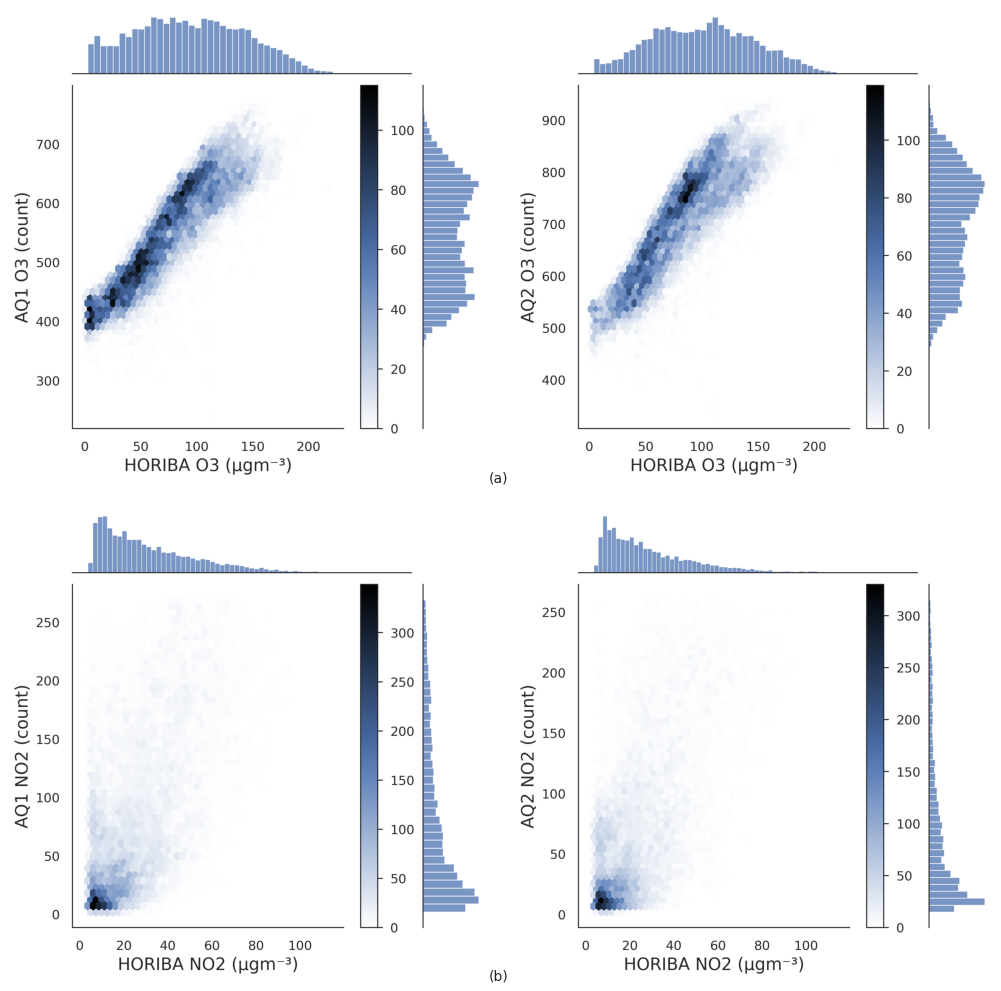

In [15]:
merge_images(["g0.png", "g1.png", "g2.png", "g3.png"], 2, 2, "figures/fig03.png", FIGURES[:2])

# Univariate Regression models


- train/test (random state=42)
- model lists:
    1. linear (LR)
    2. robust COOK (CDLR)
    3. robust Huber (HBLR)
    4. Polynomial regression 2 degree (PLR2)
    5. Polynomial regression 3 degree (PLR3)
    6. non linear power (PNLR)
    7. non linear log. (LNLR)
    8. non linear three (RF)
    9. non linear boosting (GB)
    10. linear SVM (SVR)
    11. non linear SVM (RBF)
    
- summary table: R², RMSE, MAE, MBE
- cross validation

### Linear Regression

In [16]:
def linear(X_train, y_train, X_test, y_test):

    lr = LinearRegression().fit(X_train, y_train)
    y_pred=lr.predict(X_test)

    type_regression='LR'
    r2= r2_score(y_test, y_pred)
    RMSE_regression=mean_squared_error(y_test, y_pred, squared=False)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression=mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"param": pollutant, 
            "regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

### Cook regression

In [17]:
def cook(X_train, y_train, X_test, y_test):
    X_train_=sm.add_constant(X_train)
    model = sm.OLS(y_train,X_train_)
    fitted = model.fit()


    infl= fitted.get_influence()

    threshold=3/len(X.index)

    X_train_['cook']= infl.cooks_distance[0]

    mask = X_train_['cook']<threshold


    X_train_=sm.add_constant(X_train_[mask])
    model = sm.OLS(y_train[mask],X_train_)
    fitted = model.fit()


    y_pred=fitted.params[1]*X_test+fitted.params[0]


    type_regression='CDLR'
    r2= r2_score(y_test, y_pred)
    RMSE_regression=mean_squared_error(y_test, y_pred, squared=False)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=round(np.mean(y_test.values - y_pred.values),6)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

### Huber regression

In [18]:
def huber(X_train, y_train, X_test, y_test):
    huber = HuberRegressor().fit(X_train, y_train)
    y_pred=  huber.predict(X_test)
    type_regression='HBLR'
    r2= r2_score(y_test, y_pred)
    RMSE_regression= rmse(y_test, y_pred)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }


### Polynomial regressions

In [19]:
def poly2(X_train, y_train, X_test, y_test):
    
    p=X_train.iloc[:, 0].values
    poly2 = np.poly1d(np.polyfit(p, y_train, 2))

    y_pred=np.concatenate(poly2(X_test)).ravel()

    type_regression='PLR2'
    r2= r2_score(y_test, y_pred)
    RMSE_regression=mean_squared_error(y_test, y_pred, squared=False)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression=mean_absolute_error(y_test, y_pred)
    mbe_regression=np.mean(y_test - y_pred)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

def poly3(X_train, y_train, X_test, y_test):
    
    p=X_train.iloc[:, 0].values
    poly2 = np.poly1d(np.polyfit(p, y_train, 2))

    y_pred=np.concatenate(poly2(X_test)).ravel()
    poly3 = np.poly1d(np.polyfit(p, y_train, 3))

    y_pred=np.concatenate(poly3(X_test)).ravel()

    type_regression='PLR3'
    r2= r2_score(y_test, y_pred)
    RMSE_regression=mean_squared_error(y_test, y_pred, squared=False)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression=mean_absolute_error(y_test, y_pred)
    mbe_regression=np.mean(y_test - y_pred)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }


### Non linear regressions

In [20]:
def log_reg(X_train, y_train, X_test, y_test):
    X_train=X_train.iloc[:, 0].values
    X_test=X_test.iloc[:, 0].values

    def log(x, a, b):
        return a*np.log(x)+b

    popt_log, _ = curve_fit(log, X_train, y_train)
    y_log_pred=log(X_test, *popt_log)

    y_pred=y_log_pred

    type_regression='LNLR'
   
    RMSE_regression= rmse(y_test, y_pred)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"regression_type": type_regression,
            "R²":0,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }


def pow_reg(X_train, y_train, X_test, y_test):
    X_train=X_train.iloc[:, 0].values
    X_test=X_test.iloc[:, 0].values

    def funcPow(x, a, b):
        return a*b**x

    popt_exp, _ = curve_fit(funcPow, X_train, y_train)
    y_exp_pred=funcPow(X_test, *popt_exp)

    y_pred=y_exp_pred

    type_regression='PNLR'
    
    RMSE_regression=rmse(y_test, y_pred)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"regression_type": type_regression,
            "R²":0,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
            }

### Non linear three-models

In [21]:
def randomForest(X_train, y_train, X_test, y_test):
    X_tr=X_train.values.reshape(-1, 1)
    y_tr=y_train.values.reshape(-1, 1)
    X_ts=X_test.values.reshape(-1, 1)
    y_ts=y_test.values.reshape(-1, 1)
    rf = RandomForestRegressor(n_estimators = 100, random_state=42)
    fit_rf=rf.fit(X_tr, y_tr)
    score=fit_rf.score(X_ts, y_ts);

    y_pred = rf.predict(X_ts)

    type_regression='RF'
    r2= score
    RMSE_regression= rmse(y_test, y_pred)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }


In [22]:
def gradientBoosting(X_train, y_train, X_test, y_test):
    X_tr=X_train.values.reshape(-1, 1)
    y_tr=y_train.values.reshape(-1, 1)
    X_ts=X_test.values.reshape(-1, 1)
    y_ts=y_test.values.reshape(-1, 1)

    gb = GradientBoostingRegressor(random_state=42)

    fit_gr=gb.fit(X_tr, y_tr)
    score=fit_gr.score(X_ts, y_ts);

    y_pred = gb.predict(X_ts)

    type_regression='GB'
    r2= score
    RMSE_regression=  rmse(y_test, y_pred)
    max_error_regression=max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=bias(y_test, y_pred)

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

### SVR


In [23]:
svregressor = LinearSVR()
for pollutant in POLLUTANTS:
    for aq in AQS:
        y = union[aq].dropna()["horiba_%s"%pollutant]
        X = union[aq].dropna()[["aq_%s"%pollutant]]
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)    
        param_grid={'svr__C': [1, 10, 100]}
        pipe = Pipeline([
            ('scaler', StandardScaler()), 
                         ('svr', LinearSVR(max_iter=100000, random_state=42))])
        grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1, verbose=0)
        grid_search=grid_search.fit(X_test,y_test)
        print(pollutant,aq)
        print(grid_search.best_params_)


O3 AQ1
{'svr__C': 100}
O3 AQ2
{'svr__C': 10}
NO2 AQ1
{'svr__C': 10}
NO2 AQ2
{'svr__C': 100}


In [24]:
def svm(X_train, y_train, X_test, y_test,C):
    regr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=100000,random_state=42,C=C))
    regr.fit(X_train, y_train)
    y_pred= regr.predict(X_test)
    type_regression='SVR'
    r2= regr.score(X_test,y_test)
    RMSE_regression=  rmse(y_test, y_pred)
    max_error_regression= max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=np.mean(bias(y_test, y_pred))

    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

### RBF

In [25]:
for pollutant in POLLUTANTS:
    for aq in AQS:
        y = union[aq].dropna()["horiba_%s"%pollutant]
        X = union[aq].dropna()[["aq_%s"%pollutant]]
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)        
        param_grid = {'svr__epsilon': [1,0.1,0.01,0.001]}
        pipe = Pipeline([
            ('scaler', StandardScaler()), 
                         ('svr', SVR(kernel='rbf',max_iter=100000))])
        grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1, verbose=0)
        grid_search=grid_search.fit(X_test,y_test)
        print(pollutant,aq)
        print(grid_search.best_params_)
        print(grid_search.best_score_)

O3 AQ1
{'svr__epsilon': 0.1}
0.812842346481699
O3 AQ2
{'svr__epsilon': 1}
0.7611824382505137
NO2 AQ1
{'svr__epsilon': 1}
0.33176954724879665
NO2 AQ2
{'svr__epsilon': 0.01}
0.35985973628182094


In [26]:
def svmRbf(X_train, y_train, X_test, y_test,epsilon):
    regr = SVR(kernel="rbf", epsilon=epsilon, gamma='auto')#default C=100, gamma=auto, epsilon=0.1)
    regr.fit(X_train, y_train)
    y_pred= regr.predict(X_test)
    type_regression='RBF'
    r2= regr.score(X_test,y_test)
    RMSE_regression=  rmse(y_test, y_pred)
    max_error_regression= max_error(y_test, y_pred)
    mae_perc=mean_absolute_percentage_error(y_test, y_pred)
    mae_regression= mean_absolute_error(y_test, y_pred)
    mbe_regression=np.mean(bias(y_test, y_pred))
    return {"regression_type": type_regression,
            "R²":r2,
            "RMSE":RMSE_regression,
            "MAX error":max_error_regression,
            "MAE":mae_regression,
            "MAPE":mae_perc,
            "MBE":mbe_regression
           }

# Univariate models pipeline

The literature recommends an epsilon between 1-e3 and 1. Concerning the C parameter a good hyperparameter space would be between 1 and 100. A C that is too large will simply overfit the training data.
The gamma is already calculated by scikit-learn SVR.
http://adrem.uantwerpen.be/bibrem/pubs/IJCNN2007.pdf

In [27]:
params = {'AQ1': {'svmRbf': {'O3': {'epsilon': 0.1},
          'NO2': {'epsilon': 1}},
          'svm': {'O3': {'C': 100}, 'NO2': {'C': 10}}},
          'AQ2': {'svmRbf': {'O3': {'epsilon': 1},
          'NO2': {'epsilon': 0.01}},
          'svm': {'O3': {'C': 10}, 'NO2': {'C': 100}}}}

In [28]:
table_results = pd.DataFrame(columns=["aq","pollutant","regression_type","R²","RMSE",'MAX error','MAE','MAPE','MBE'])
for pollutant in POLLUTANTS:
    for aq in AQS:
        y = union[aq]["horiba_%s"%pollutant]
        X = union[aq][["aq_%s"%pollutant]]
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)        
        for reg in [linear, poly2, poly3, cook, huber, log_reg, pow_reg, randomForest, gradientBoosting, svm, svmRbf]:
            results = {"id_airqino": aq, "param": pollutant}
            results.update(reg(X_train, y_train, X_test, y_test,**params.get(aq,{}).get(reg.__name__,{}).get(pollutant,{})))
            table_results = table_results.append(results, ignore_index=True)

/home/alice/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/alice/.local/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/alice/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/home/alice/.local/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/alice/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: Da

# Univariate summary table

In [29]:
replaces = {"toprule": "tophline",
            "midrule": "middlehline",
            "bottomrule": "bottomhline",
            "²": "$^2$",
           }

def header(df, column_groups = None):
    results = ""
    if column_groups:
        for i in df.index.names:
            results += " & "
        for k, v in column_groups.items():
            results +="\\multicolumn{"+str(v)+"}{c}{" + k.replace("_", "\_") + "} & "
        results = results[:-2] +"\\\\\n"
    for i in df.index.names:
        results += i.replace("_", "\_") + " & "
    for i in df.columns:
        if type(i) == str:
            results += i.replace("_", "\_") + " & "
        else:
            results += i[-1].replace("_", "\_") + " & "
    results = results[:-2] +"\\\\\n"
    return "\\toprule\n"+results+"\midrule"

def to_my_latex(df, column_groups = {}, filename=None):
    latex = df.to_latex(float_format=float_format, multirow=True)
    latex = latex.replace("\\toprule", header(df, column_groups))
    count = 0
    new_latex = ""
    for l in latex.split("\n"):
        if l.startswith("\\midrule"):
            count += 1
        if count == 1:
            continue
        new_latex += l + "\n" 
    latex = new_latex
    for k, v in replaces.items():
        latex = latex.replace(k, v)
    latex = "\\begin{table}\n"+latex[:-1]+"\end{table}"
    if filename:
        with open(filename, "w") as f:
            f.write(latex)
    else:
        return latex


In [30]:
monoparametric_summary = table_results
monoparametric_summary["id_airqino"] = monoparametric_summary["id_airqino"]
monoparametric_summary = monoparametric_summary[["id_airqino", "param", "regression_type", "R²", "RMSE", "MAE", "MBE"]].melt(
    id_vars=["id_airqino", "param", "regression_type"], var_name="Stat.", value_name="Value", ignore_index=False).pivot_table(
    columns=["regression_type"], values=["Value"], index=["param", "id_airqino", "Stat."], sort=False)
monoparametric_summary = monoparametric_summary["Value"][table_results['regression_type'].unique()]
monoparametric_summary.index = monoparametric_summary.index.rename(["Pollutant", "AQ id","Stat."])
monoparametric_summary.to_html(open('figures/tab01.html', 'w'), float_format=float_format)
to_my_latex(monoparametric_summary,
            column_groups={"SLR": 5, "SNLR": 4, "SVM": 2},
            filename='figures/tab01.tex')
monoparametric_summary

regression_type          LR  PLR2  PLR3  CDLR  HBLR  LNLR  PNLR    RF    GB  \
Pollutant AQ id Stat.                                                         
O3        AQ1   R²     0.81  0.81  0.82  0.81  0.81  0.00  0.00  0.82  0.82   
                RMSE  16.92 16.92 16.75 16.99 17.00 17.15 18.85 16.78 16.58   
                MAE   13.42 13.41 13.40 13.19 13.18 13.47 14.94 13.42 13.27   
                MBE   -0.28 -0.28 -0.30  1.56  1.69 -0.33 -0.96 -0.18 -0.20   
          AQ2   R²     0.77  0.77  0.77  0.76  0.77  0.00  0.00  0.77  0.78   
                RMSE  17.58 17.55 17.41 17.86 17.75 17.97 18.46 17.58 17.36   
                MAE   14.11 14.10 14.10 13.81 13.85 14.30 14.79 14.18 14.05   
                MBE    0.14  0.14  0.15  3.03  2.39  0.19 -0.48  0.24  0.14   
NO2       AQ1   R²     0.34  0.34  0.34  0.32  0.33  0.00  0.00  0.33  0.35   
                RMSE  14.22 14.18 14.16 14.40 14.28 14.51 14.46 14.35 14.14   
                MAE   10.91 10.84 10.82 10.77 10.79 11.20 11.22 10.84 10.75   
                MBE    0.09  0.11  0.11  2.26  1.21  0.16 -0.11  0.06  0.09   
          AQ2   R²     0.38  0.38  0.38  0.35  0.37  0.00  0.00  0.36  0.38   
                RMSE  12.86 12.85 12.85 13.12 12.95 13.45 13.06 13.04 12.85   
                MAE    9.83  9.83  9.84  9.69  9.69 10.37 10.06  9.94  9.81   
                MBE   -0.09 -0.09 -0.09  2.56  1.53 -0.05 -0.24 -0.05 -0.10   

regression_type         SVR   RBF  
Pollutant AQ id Stat.              
O3        AQ1   R²     0.81  0.70  
                RMSE  17.18 21.31  
                MAE   13.12 16.06  
                MBE    2.89  3.53  
          AQ2   R²     0.76  0.60  
                RMSE  18.11 23.06  
                MAE   13.79 17.38  
                MBE    4.17  3.55  
NO2       AQ1   R²     0.33  0.31  
                RMSE  14.35 14.50  
                MAE   10.76 10.81  
                MBE    1.73  2.08  
          AQ2   R²     0.36  0.32  
                RMSE  13.02 13.39  
                MAE    9.67  9.83  
                MBE    2.05  2.60

# Multiple regression
1. cross_validate intT vs extT
2. stepwise regression with parameter permutation (O3 count, NO2 count, intT, RH)
2. summary table (R², MAE, RMSE, AIC) 
3. VIF valutation   
    

In [31]:
results = []

for pollutant in POLLUTANTS:
    for aq in AQS:
        result = [{"AQ id": aq, "Pollutant": pollutant}, {"AQ id": aq, "Pollutant": pollutant}]
        for temperature in ["aq_intT", "aq_extT"]:
            union[aq].dropna(subset=["aq_O3", "aq_NO2", temperature, "aq_RH"], inplace=True)
            X = union[aq][["aq_O3", "aq_NO2", temperature, "aq_RH"]]
            y = union[aq][f"horiba_{pollutant}"]
            split = TimeSeriesSplit(n_splits=5)          
            scoring = {
            'acc': 'r2',
            'rmse': 'neg_mean_squared_error',
           
            }
            scores = cross_validate(LinearRegression(), X, y, scoring=scoring,
                                     cv=split, return_train_score=True)          
            result[0]["Stat."] = "R²"
            result[0][f'O3,NO2,{temperature.replace("aq_", "")},RH'] = f"{scores['test_acc'].mean().round(2):.2f}±{scores['test_acc'].std():.2f}"
            result[1]["Stat."] = "RMSE"
            result[1][f'O3,NO2,{temperature.replace("aq_", "")},RH'] = f"{np.sqrt(np.abs(scores['test_rmse'])).mean():.2f}±{np.sqrt(np.abs(scores['test_rmse'])).std():.2f}"
        results += result
tmp = pd.DataFrame(results)
tmp.set_index(["AQ id", "Pollutant", "Stat."], inplace=True)
tmp.to_html(open('figures/tab02.html', 'w'), float_format=float_format)
to_my_latex(tmp,column_groups={"Covariate set (meanSD": 2}, filename='figures/tab02.tex')
tmp

O3,NO2,intT,RH O3,NO2,extT,RH
AQ id Pollutant Stat.                              
AQ1   O3        R²         0.93±0.03      0.93±0.02
                RMSE       9.52±2.51      9.55±2.10
AQ2   O3        R²         0.91±0.04      0.91±0.05
                RMSE       9.52±2.86      9.72±2.85
AQ1   NO2       R²         0.57±0.21      0.56±0.24
                RMSE      10.75±1.31     10.83±1.43
AQ2   NO2       R²         0.61±0.07      0.61±0.07
                RMSE       9.87±2.07      9.89±2.02

In [32]:
linreg = LinearRegression()

table_results_mp = pd.DataFrame(columns= ["AQ id", "Pollutant", "β0","β1","β2", "β3", "β4","R²","RMSE",'AIC'])

def _getcoeff(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
    linreg.fit(X_train, y_train)
    n = X_train.shape[0]
    k = X_train.shape[1]
    y_pred = linreg.predict(X_train)
    rss = sum((y_train - y_pred) ** 2)
    llf = -(n / 2) * np.log(2 * np.pi) - (n / 2) * np.log(rss / n) - n / 2
    return n, k, llf

def AIC(X,y): 
    n, k, llf = _getcoeff(X, y)
    aic = -2 * llf + 2 * k
    aicc = aic  + 2 * k * (k + 1) / (n - k - 1)
    return (aic,aicc)


def ADJ(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    return adjusted_r_squared

def MBE(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
    linreg.fit(X_train, y_train)
    y_hat = linreg.predict(X_test)
    mbe=bias(y_test, y_hat)
    return mbe   

  

def lin_reg(X, y, predictors):
    global table_results_mp
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
    regression=linreg.fit(X_train, y_train)
    y_hat = linreg.predict(X_test)  
    result = {"Variables":predictors,
              "β0": np.round(linreg.intercept_,6),               
              "R²":round(linreg.score(X_test, y_test),3),
              "RMSE": round(np.sqrt(mse(y_test, y_hat)),3),
              "MBE":MBE(X, y),
              "MAE":mean_absolute_error(y_test, y_hat),  
              "AdjR²" :ADJ(X, y), 
              "AIC":AIC(X, y)[0]
             }
    for i,x in enumerate(linreg.coef_):
        result['β%d'%(i+1)] = x

    return result

def clean_predictors(predictors):
    return ",".join([x.replace("aq_", "") for x in sorted(predictors)])

In [33]:
for pollutant, other in zip(POLLUTANTS, POLLUTANTS[::-1]):
    for aq in AQS:    
        y=union[aq]['horiba_%s'%pollutant]
        regression_predictors = []
       
        for i in range(1, 5):
            regression_predictors += combinations(['aq_%s'%pollutant,'aq_intT','aq_RH','aq_%s'%other], i)

        for predictor in regression_predictors:
            X=union[aq][sorted(list(predictor))]
            X.dropna() 
            results = {"AQ id": aq, "Pollutant": pollutant}
            results.update(lin_reg(X, y, clean_predictors(predictor)))
            table_results_mp = table_results_mp.append(results, ignore_index=True)            

tmp = table_results_mp.set_index(["Pollutant", "AQ id", "Variables"]).fillna("-")
tmp['AIC'] = tmp['AIC'].apply(lambda val: '%.2E' % val)

In [34]:
tmp[[x for x in tmp.columns if x != "R²"]].to_html(open('figures/sup_tab01.html', 'w'), float_format=float_format)
for pollutant in POLLUTANTS:
    to_my_latex(tmp[tmp.index.get_level_values("Pollutant") == pollutant], column_groups={"Coefficient": 5, "Stat.": 6}, filename=f'figures/sup_tab01_{pollutant}.tex')
    display(tmp[tmp.index.get_level_values("Pollutant") == pollutant])

β0    β1    β2    β3   β4   R²  RMSE  \
Pollutant AQ id Variables                                                  
O3        AQ1   O3             -146.10  0.40     -     -    - 0.81 16.92   
                intT           -109.92  5.46     -     -    - 0.61 24.33   
                RH              165.02 -1.71     -     -    - 0.57 25.61   
                NO2              97.15 -0.31     -     -    - 0.27 33.63   
                O3,intT        -186.58  0.30  2.88     -    - 0.94  9.92   
                O3,RH           -61.47  0.32 -0.71     -    - 0.88 13.61   
                NO2,O3         -162.73  0.05  0.43     -    - 0.82 16.74   
                RH,intT         -12.71 -0.71  3.70     -    - 0.65 23.07   
                NO2,intT        -84.20 -0.29  5.36     -    - 0.86 14.52   
                NO2,RH          170.74 -0.21 -1.52     -    - 0.69 21.88   
                O3,RH,intT     -193.19  0.30  0.04  2.97    - 0.94  9.93   
                NO2,O3,intT    -159.76 -0.10  0.23  3.44    - 0.95  8.69   
                NO2,O3,RH       -64.32  0.01  0.32 -0.71    - 0.88 13.60   
                NO2,RH,intT     -87.77 -0.29  0.03  5.42    - 0.86 14.52   
                NO2,O3,RH,intT -180.76 -0.11  0.23  0.15 3.79 0.95  8.62   
          AQ2   O3             -140.53  0.31     -     -    - 0.77 17.58   
                intT            -90.68  5.04     -     -    - 0.64 22.12   
                RH              148.13 -1.37     -     -    - 0.55 24.62   
                NO2             101.33 -0.34     -     -    - 0.31 30.43   
                O3,intT        -174.35  0.23  2.86     -    - 0.91 10.86   
                O3,RH           -59.90  0.24 -0.61     -    - 0.84 14.77   
                NO2,O3         -139.86 -0.00  0.31     -    - 0.77 17.58   
                RH,intT          -9.43 -0.60  3.52     -    - 0.69 20.50   
                NO2,intT        -62.83 -0.30  4.79     -    - 0.89 12.22   
                NO2,RH          150.72 -0.21 -1.15     -    - 0.65 21.64   
                O3,RH,intT     -155.80  0.22 -0.12  2.62    - 0.91 10.76   
                NO2,O3,intT    -129.74 -0.16  0.14  3.51    - 0.94  8.59   
                NO2,O3,RH       -53.73 -0.02  0.24 -0.62    - 0.84 14.76   
                NO2,RH,intT     -60.82 -0.30 -0.02  4.76    - 0.89 12.21   
                NO2,O3,RH,intT -133.43 -0.16  0.14  0.03 3.58 0.94  8.58   

                                     AIC  AdjR²   MAE   MBE  
Pollutant AQ id Variables                                    
O3        AQ1   O3              1.09E+05   0.81 13.42 -0.28  
                intT            1.19E+05   0.62 19.56  0.21  
                RH              1.21E+05   0.57 20.35 -0.17  
                NO2             1.27E+05   0.27 27.42 -0.46  
                O3,intT         9.52E+04   0.94  7.39 -0.06  
                O3,RH           1.04E+05   0.88 10.69 -0.26  
                NO2,O3          1.09E+05   0.82 13.24 -0.23  
                RH,intT         1.17E+05   0.65 18.21  0.09  
                NO2,intT        1.05E+05   0.86 11.35 -0.11  
                NO2,RH          1.17E+05   0.69 17.50 -0.39  
                O3,RH,intT      9.52E+04   0.94  7.39 -0.06  
                NO2,O3,intT     9.18E+04   0.95  6.39 -0.12  
                NO2,O3,RH       1.04E+05   0.88 10.69 -0.26  
                NO2,RH,intT     1.05E+05   0.86 11.36 -0.11  
                NO2,O3,RH,intT  9.14E+04   0.95  6.30 -0.10  
          AQ2   O3              9.93E+04   0.77 14.11  0.14  
                intT            1.04E+05   0.64 18.07 -0.24  
                RH              1.07E+05   0.55 19.48 -0.29  
                NO2             1.12E+05   0.31 24.74  0.23  
                O3,intT         8.83E+04   0.91  8.18 -0.05  
                O3,RH           9.51E+04   0.84 11.96 -0.03  
                NO2,O3          9.93E+04   0.77 14.11  0.14  
                RH,intT         1.03E+05   0.69 16.33 -0.30  
                NO2,intT        9.07E+04   0.89  9.52

β0    β1    β2    β3    β4   R²  RMSE  \
Pollutant AQ id Variables                                                  
NO2       AQ1   NO2             13.03  0.15     -     -     - 0.34 14.22   
                intT            70.28 -1.36     -     -     - 0.19 15.72   
                RH               2.19  0.42     -     -     - 0.18 15.81   
                O3             111.52 -0.16     -     -     - 0.66 10.22   
                NO2,intT        57.18  0.15 -1.30     -     - 0.52 12.14   
                NO2,RH          -1.44  0.13  0.30     -     - 0.42 13.28   
                NO2,O3         101.09  0.03 -0.14     -     - 0.67 10.09   
                RH,intT         47.73  0.17 -0.95     -     - 0.20 15.59   
                O3,intT        111.23 -0.16  0.02     -     - 0.66 10.22   
                O3,RH          127.09 -0.18 -0.13     -     - 0.67 10.10   
                NO2,RH,intT     89.29  0.16 -0.24 -1.90     - 0.53 11.96   
                NO2,O3,intT    100.92  0.04 -0.13 -0.19     - 0.67 10.06   
                NO2,O3,RH      116.25  0.02 -0.16 -0.11     - 0.67 10.01   
                O3,RH,intT     150.78 -0.17 -0.27 -0.54     - 0.68  9.97   
                NO2,O3,RH,intT 144.78  0.05 -0.14 -0.32 -0.93 0.69  9.68   
          AQ2   NO2             11.81  0.16     -     -     - 0.38 12.86   
                intT            66.88 -1.31     -     -     - 0.21 14.45   
                RH               4.94  0.35     -     -     - 0.19 14.67   
                O3             113.00 -0.13     -     -     - 0.64  9.79   
                NO2,intT        52.45  0.16 -1.19     -     - 0.55 10.91   
                NO2,RH           3.19  0.14  0.20     -     - 0.43 12.28   
                NO2,O3          97.76  0.05 -0.11     -     - 0.66  9.53   
                RH,intT         47.54  0.14 -0.95     -     - 0.23 14.28   
                O3,intT        114.00 -0.13 -0.08     -     - 0.64  9.78   
                O3,RH          123.40 -0.14 -0.08     -     - 0.64  9.72   
                NO2,RH,intT     77.38  0.17 -0.20 -1.67     - 0.57 10.71   
                NO2,O3,intT     96.78  0.06 -0.10 -0.34     - 0.67  9.41   
                NO2,O3,RH      107.47  0.04 -0.12 -0.07     - 0.66  9.48   
                O3,RH,intT     137.80 -0.13 -0.15 -0.39     - 0.65  9.63   
                NO2,O3,RH,intT 126.78  0.08 -0.10 -0.23 -0.87 0.69  9.07   

                                     AIC  AdjR²   MAE   MBE  
Pollutant AQ id Variables                                    
NO2       AQ1   NO2             1.05E+05   0.34 10.91  0.09  
                intT            1.07E+05   0.19 12.14 -0.16  
                RH              1.08E+05   0.18 12.25 -0.07  
                O3              9.61E+04   0.66  7.74 -0.01  
                NO2,intT        1.01E+05   0.52  9.17  0.01  
                NO2,RH          1.03E+05   0.42  9.99  0.08  
                NO2,O3          9.57E+04   0.67  7.64  0.01  
                RH,intT         1.07E+05   0.20 12.02 -0.13  
                O3,intT         9.61E+04   0.66  7.74 -0.01  
                O3,RH           9.57E+04   0.67  7.67 -0.01  
                NO2,RH,intT     1.00E+05   0.53  9.09 -0.02  
                NO2,O3,intT     9.57E+04   0.67  7.61  0.01  
                NO2,O3,RH       9.55E+04   0.67  7.61  0.01  
                O3,RH,intT      9.53E+04   0.67  7.57 -0.05  
                NO2,O3,RH,intT  9.45E+04   0.69  7.36 -0.03  
          AQ2   NO2             9.22E+04   0.38  9.83 -0.09  
                intT            9.49E+04   0.21 10.91  0.07  
                RH              9.54E+04   0.19 11.09  0.08  
                O3              8.58E+04   0.64  7.35 -0.04  
                NO2,intT        8.85E+04   0.55  8.19 -0.01  
                NO2,RH          9.12E+04   0.43  9.25 -0.03  
                NO2,O3          8.52E+04   0.66  7.15 -0.06  
                RH,intT         9.47E+04   0.23 10.73  0.08  
                O3,intT         8.58E+04   0.64  7.3

In [35]:
tmp2 = tmp.query("Variables == 'NO2,O3,RH,intT'").droplevel(2)
tmp2 = tmp2[[x for x in tmp2.columns if x not in ["R²", "RMSE", "AIC", "MAE", "MBE"]]]
tmp2.to_html(open('figures/tab03.html', 'w'), float_format=float_format)
to_my_latex(tmp2, column_groups={"Coefficient": 5, "Stat.": 1}, filename='figures/tab03.tex')
tmp2

β0    β1    β2    β3    β4  AdjR²
Pollutant AQ id                                       
O3        AQ1   -180.76 -0.11  0.23  0.15  3.79   0.95
          AQ2   -133.43 -0.16  0.14  0.03  3.58   0.95
NO2       AQ1    144.78  0.05 -0.14 -0.32 -0.93   0.69
          AQ2    126.78  0.08 -0.10 -0.23 -0.87   0.69

### VIF

In [36]:
vifs = []

def calc_vif(X):
    # Calculating VIF
    row = dict(zip([x.replace("aq_", "") for x in X.columns], [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
    row["Variables"] = ",".join([x.replace("aq_", "") for x in X.columns[1:]])
    row["Pollutant"] = pollutant
    row["AQ id"] = aq
    return(row)

for pollutant, other in zip(POLLUTANTS, POLLUTANTS[::-1]):
    for aq in AQS:

        df_z = union[aq].select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
        X1=df_z[['aq_%s'%pollutant,'aq_intT']]

        formule = ["horiba_%s ~ aq_%s +aq_intT"%(pollutant, pollutant),
                   "horiba_%s ~ aq_%s+aq_intT+aq_RH"%(pollutant, pollutant),
                   "horiba_%s ~ aq_%s+aq_intT+aq_extT+aq_RH"%(pollutant, pollutant),
                   "horiba_%s ~ aq_%s+aq_%s+aq_intT+aq_RH"%(pollutant, pollutant, other),
                   "horiba_%s ~ aq_%s+aq_%s+aq_intT+aq_extT+aq_RH"%(pollutant, pollutant, other),
                  ]
        for formula in formule:
            _, X1 = dmatrices(formula, data=union[aq], return_type='dataframe')

            vifs.append(calc_vif(X1))

dfvif = pd.DataFrame(vifs).set_index(["Pollutant", "AQ id", "Variables"]).fillna("-")
dfvif = dfvif.reindex(['Intercept', 'O3', 'NO2', 'intT', 'extT', 'RH'], axis=1)


to_my_latex(dfvif, filename=f'figures/sup_vif.tex')


# Multiple models summary (MLR, MRF, MGB)

In [37]:
mlr_summary=pd.DataFrame()
regressors = {"MLR":{}, "MGB":{}, "MRF":{}}
for aq in AQS:
    regressors["MLR"][aq] = {}
    regressors["MGB"][aq] = {}
    regressors["MRF"][aq] = {}
    for pollutant in POLLUTANTS:
        y = union[aq]["horiba_%s"%pollutant]
        X = union[aq][["aq_O3","aq_NO2","aq_intT","aq_RH"]]
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
        

        regressors["MLR"][aq][pollutant] = LinearRegression().fit(X_train, y_train)
        
        y_pred = regressors["MLR"][aq][pollutant].predict(X_test)
        mlr_summary = mlr_summary.append({
            "regression_type":"MLR",
            "id_airqino":aq,
            "param":pollutant,
            "AdjR²": 1-(1-regressors["MLR"][aq][pollutant].score(X_test, y_test))*(y_test.size-1)/(y_test.size-X_test.shape[1]-1),
            "RMSE": np.sqrt(mse(y_test, y_pred)),
            "MAE":mean_absolute_error(y_test, y_pred),
            "MBE":bias(y_test, y_pred)
        }, ignore_index=True)
       
        regressors["MGB"][aq][pollutant] = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
        y_pred = regressors["MGB"][aq][pollutant].predict(X_test)
        mlr_summary = mlr_summary.append({
            "regression_type":"MGB",
            "id_airqino":aq,
            "param":pollutant,
            "AdjR²": 1-(1-regressors["MGB"][aq][pollutant].score(X_test, y_test))*(y_test.size-1)/(y_test.size-X_test.shape[1]-1),
            "RMSE": np.sqrt(mse(y_test, y_pred)),
            "MAE":mean_absolute_error(y_test, y_pred),
            "MBE":bias(y_test, y_pred)
        }, ignore_index=True)

        regressors["MRF"][aq][pollutant] = RandomForestRegressor(n_estimators = 100, random_state=42, max_depth=10,oob_score=True).fit(X_train, y_train)
        y_pred = regressors["MRF"][aq][pollutant].predict(X_test)
        mlr_summary = mlr_summary.append({
            "regression_type":"MRF",
            "id_airqino":aq,
            "param":pollutant,
            "AdjR²": 1-(1-regressors["MRF"][aq][pollutant].score(X_test, y_test))*(y_test.size-1)/(y_test.size-X_test.shape[1]-1),
            "RMSE": np.sqrt(mse(y_test, y_pred)),
            "MAE":mean_absolute_error(y_test, y_pred),
            "MBE":bias(y_test, y_pred)
        }, ignore_index=True)

In [38]:
mlr_summary = mlr_summary[["id_airqino", "param", "regression_type", "AdjR²", "RMSE", "MAE", "MBE"]].melt(
id_vars=["id_airqino", "param", "regression_type"], var_name="Stat.", value_name="Value", ignore_index=False).pivot_table(
columns=["regression_type"], values=["Value"], index=["param", "id_airqino", "Stat."], sort=False)[[('Value', 'MLR'),
            ('Value', 'MGB'),
            ('Value', 'MRF')]]
mlr_summary.index = mlr_summary.index.rename(["Pollutant", "AQ id","Stat."])
mlr_summary.to_html("figures/tab04.html", float_format=float_format)
to_my_latex(mlr_summary, column_groups={"Multiple models": 3}, filename='figures/tab04.tex')
mlr_summary

Value            
regression_type         MLR   MGB   MRF
Pollutant AQ id Stat.                  
O3        AQ1   AdjR²  0.95  0.97  0.98
                RMSE   8.62  7.30  6.04
                MAE    6.30  5.40  4.31
                MBE   -0.10 -0.01 -0.01
          AQ2   AdjR²  0.95  0.96  0.98
                RMSE   8.58  6.86  5.51
                MAE    6.50  5.17  4.05
                MBE   -0.03 -0.03  0.09
NO2       AQ1   AdjR²  0.69  0.80  0.86
                RMSE   9.68  7.84  6.63
                MAE    7.36  5.75  4.72
                MBE   -0.03  0.06  0.06
          AQ2   AdjR²  0.69  0.80  0.85
                RMSE   9.07  7.28  6.30
                MAE    6.83  5.35  4.46
                MBE   -0.08  0.03  0.05

# Feature importance multple models
1. Dominance Analysis (DA)
2. Feature permutation (PFI)
2. Shap Analysis (SHAP)

### Dominance Analysis

In [39]:
df = pd.DataFrame()

for pollutant in POLLUTANTS:
    for aq in AQS:        
        corr_data = union[aq][["horiba_%s"%pollutant,"aq_O3","aq_NO2","aq_intT","aq_RH"]].corr()
        dominance_regression=Dominance(data=corr_data,target="horiba_%s"%pollutant,data_format=1)
        dominance_regression.incremental_rsquare()
        p=dominance_regression.dominance_stats()
        p = p.astype(float)
        p['Pollutant'] = pollutant
        p['AQ id'] = aq
        p.index = p.index.str.replace("aq_", "")        
        df = pd.concat([df,p])
        dominance_regression.dominance_level()

R Squared : 0.9540202579675849

Predictors :  ['aq_O3', 'aq_NO2', 'aq_intT', 'aq_RH']

Calculating R2 for 15 possible combinations of 4 features :


100%|██████████| 4/4 [00:00<00:00, 110.78it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 3/3 [00:00<00:00, 9085.14it/s]


#########################  Variable Dominance Calculation Done!!!!!  #########################

R Squared : 0.9439505689080201

Predictors :  ['aq_O3', 'aq_NO2', 'aq_intT', 'aq_RH']

Calculating R2 for 15 possible combinations of 4 features :


100%|██████████| 4/4 [00:00<00:00, 134.61it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 3/3 [00:00<00:00, 10989.44it/s]


#########################  Variable Dominance Calculation Done!!!!!  #########################

R Squared : 0.7003330756714703

Predictors :  ['aq_O3', 'aq_NO2', 'aq_intT', 'aq_RH']

Calculating R2 for 15 possible combinations of 4 features :


100%|██████████| 4/4 [00:00<00:00, 131.78it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 3/3 [00:00<00:00, 12774.53it/s]


#########################  Variable Dominance Calculation Done!!!!!  #########################

R Squared : 0.692281436266417

Predictors :  ['aq_O3', 'aq_NO2', 'aq_intT', 'aq_RH']

Calculating R2 for 15 possible combinations of 4 features :


100%|██████████| 4/4 [00:00<00:00, 122.29it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████| 3/3 [00:00<00:00, 12288.00it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [40]:
new_columns = {
                "Interactional Dominance": "IntD",
                "Individual Dominance": "ID",
                "Average Partial Dominance": "APD",
                "Total Dominance": "TD",
                "Percentage Relative Importance": "PRI",
              }
tab05 = df.rename_axis('Variable').reset_index().set_index(["Pollutant", "AQ id", "Variable"]).rename(columns=new_columns)
tab05

IntD   ID  APD   TD   PRI
Pollutant AQ id Variable                           
O3        AQ1   O3        0.09 0.82 0.29 0.37 38.96
                intT      0.07 0.62 0.20 0.27 28.64
                RH        0.00 0.57 0.10 0.19 19.92
                NO2       0.02 0.26 0.10 0.12 12.47
          AQ2   O3        0.06 0.77 0.25 0.33 34.95
                intT      0.11 0.64 0.22 0.30 31.51
                RH        0.00 0.55 0.09 0.18 19.10
                NO2       0.03 0.31 0.10 0.14 14.44
NO2       AQ1   O3        0.16 0.66 0.36 0.39 55.18
                NO2       0.02 0.34 0.15 0.17 23.78
                intT      0.02 0.20 0.06 0.08 11.93
                RH        0.03 0.18 0.02 0.06  9.11
          AQ2   O3        0.12 0.64 0.33 0.35 51.13
                NO2       0.04 0.38 0.16 0.19 26.79
                intT      0.03 0.21 0.06 0.09 13.34
                RH        0.03 0.18 0.02 0.06  8.74

### PFI

In [41]:
importances = {}
for regressor in ["MRF", "MGB"]:
    result=pd.DataFrame()
    for pollutants in POLLUTANTS:
        for aq in AQS:
            y = union[aq]["horiba_%s"%pollutants]
            X = union[aq][["aq_O3","aq_NO2","aq_intT","aq_RH"]]
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
            rf = regressors[regressor][aq][pollutants]      
            perm = PermutationImportance(rf, random_state=42, n_iter=5).fit(X_test, y_test)
            w = pd.read_html(eli5.show_weights(perm, feature_names = [x.replace("aq_", "") for x in X.columns.values]).data)[0]
            w["Weight"]=w["Weight"].apply(lambda x: f'{float(x.split("±")[0]):.2f} ± {float(x.split("±")[1]):.2f}')
            w["Pollutant"] = pollutants
            w["AQ id"] = aq
            result = result.append(w, ignore_index=True)
    importances[regressor] = result.rename(columns={"Feature": "Variable"})       

In [42]:
tab_importance = tab05
tab_importance["Weight"] = importances["MRF"].set_index(["Pollutant", "AQ id", "Variable"])["Weight"]
tab_importance.to_html(open('figures/tab05.html', 'w'), float_format=float_format)
to_my_latex(tab_importance, column_groups={"DA": 5, "PFI": 1}, filename='figures/tab05.tex')
tab_importance

IntD   ID  APD   TD   PRI       Weight
Pollutant AQ id Variable                                        
O3        AQ1   O3        0.09 0.82 0.29 0.37 38.96  0.66 ± 0.01
                intT      0.07 0.62 0.20 0.27 28.64  0.48 ± 0.01
                RH        0.00 0.57 0.10 0.19 19.92  0.01 ± 0.00
                NO2       0.02 0.26 0.10 0.12 12.47  0.16 ± 0.01
          AQ2   O3        0.06 0.77 0.25 0.33 34.95  0.47 ± 0.01
                intT      0.11 0.64 0.22 0.30 31.51  0.55 ± 0.01
                RH        0.00 0.55 0.09 0.18 19.10  0.01 ± 0.00
                NO2       0.03 0.31 0.10 0.14 14.44  0.20 ± 0.01
NO2       AQ1   O3        0.16 0.66 0.36 0.39 55.18  1.12 ± 0.02
                NO2       0.02 0.34 0.15 0.17 23.78  0.21 ± 0.01
                intT      0.02 0.20 0.06 0.08 11.93  0.18 ± 0.01
                RH        0.03 0.18 0.02 0.06  9.11  0.22 ± 0.01
          AQ2   O3        0.12 0.64 0.33 0.35 51.13  1.01 ± 0.04
                NO2       0.04 0.38 0.16 0.19 26.79  0.19 ± 0.01
                intT      0.03 0.21 0.06 0.09 13.34  0.18 ± 0.01
                RH        0.03 0.18 0.02 0.06  8.74  0.16 ± 0.01

# SHAP

### SHAP MLR

In [43]:
shap.initjs()
shap_values = {}

for aq in AQS:
    shap_values[aq] = {}
    X = union[aq][["aq_O3","aq_NO2","aq_intT","aq_RH"]]
    for pollutant in POLLUTANTS:
        print(aq,pollutant)
        y = union[aq]["horiba_%s"%pollutant]
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)        
        y_pred=regressors["MLR"][aq][pollutant].predict(X_test)
        np.random.seed(42)
        masker = shap.maskers.Impute(data = X_train)
        explainer = shap.LinearExplainer(regressors["MLR"][aq][pollutant], masker=masker)        
        shap_values[aq][pollutant] = explainer(X_test)
        shap_values[aq][pollutant].feature_names = [x.replace("aq_", "") for x in shap_values[aq][pollutant].feature_names]

AQ1 O3


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

AQ1 NO2


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

AQ2 O3


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

AQ2 NO2


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

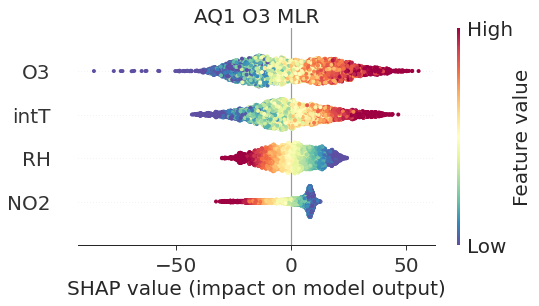

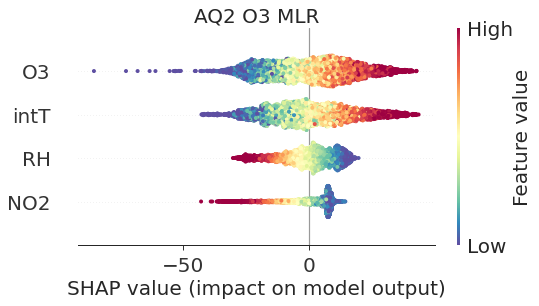

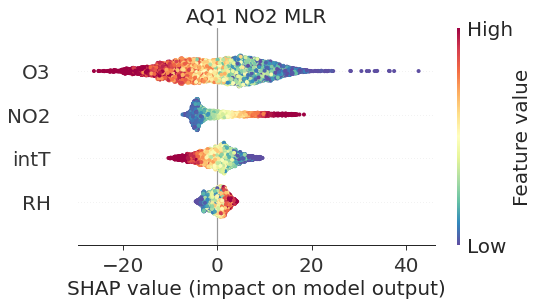

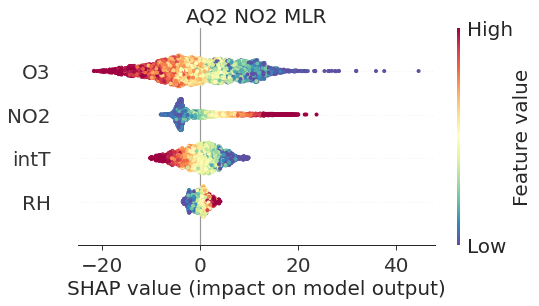

In [44]:
#Beeswarm
size = 20
for pollutant in POLLUTANTS:
    for aq in AQS:
        shap_fig=shap.plots.beeswarm(shap_values[aq][pollutant], color=plt.get_cmap("Spectral_r"), plot_size=[8,4], show=False)
        fig, ax = plt.gcf(), plt.gca()
        ax.tick_params(labelsize=size)
        ax.set_xlabel("SHAP value (impact on model output)", fontsize=size)
        # Get colorbar
        cb_ax = fig.axes[1] 
        # Modifying color bar parameters
        cb_ax.tick_params(labelsize=size)
        cb_ax.set_ylabel("Feature value", fontsize=size)      
        plt.title("%s %s MLR"%(aq,pollutant),fontsize=size)              
        plt.savefig(f"fig05_{aq}_{pollutant}.png", bbox_inches='tight', dpi=300)
        plt.show()        

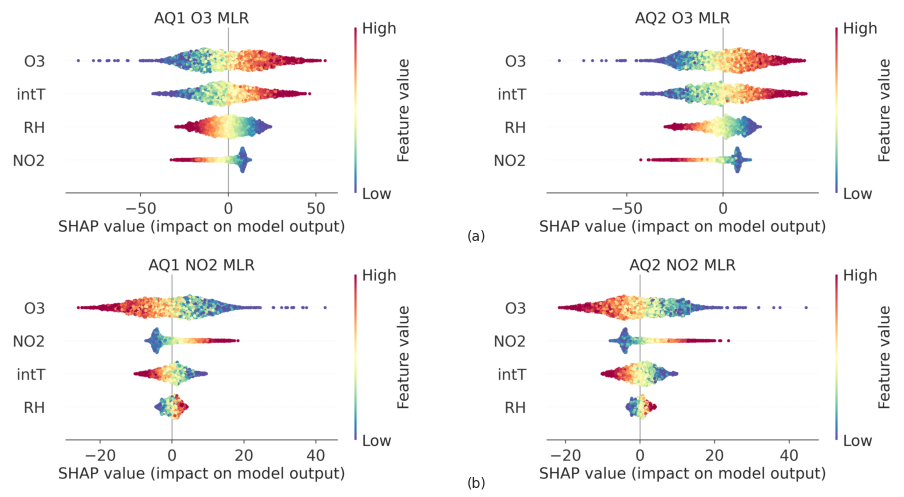

In [45]:
merge_images([f"fig05_{aq}_{pollutant}.png"  for aq in AQS for pollutant in POLLUTANTS], 2, 2, "figures/fig05.png", FIGURES[:2], ratio=0.5)

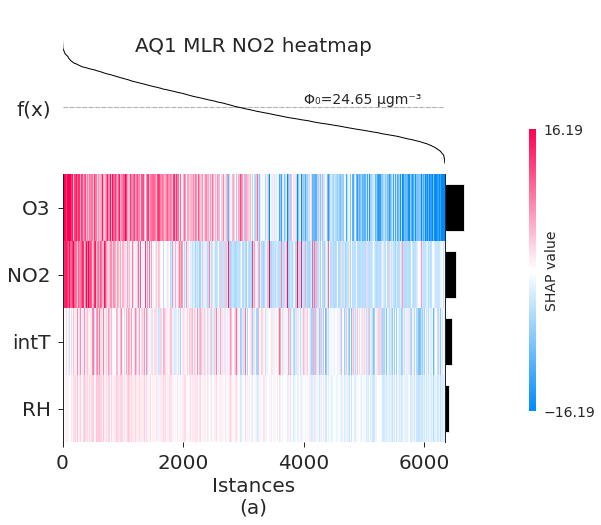

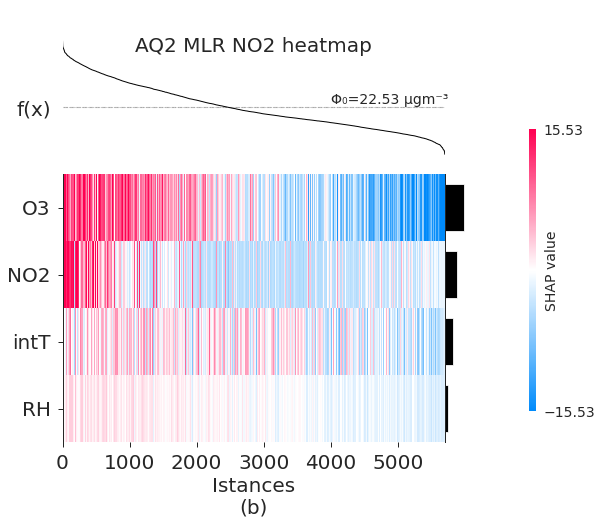

In [46]:
#HEATMAP NO2 MLR model
#shap.order.hclust is time consuming
for j,aq in enumerate(AQS):   
    np.random.seed(10)
    tmp = shap_values[aq]["NO2"][np.random.choice(len(shap_values[aq]["NO2"]), len(shap_values[aq]["NO2"]), replace=False)]
    shap.plots.heatmap(tmp,
                       instance_order=tmp.sum(1), 
                       show=False)   
    base_value=shap_values[aq]["NO2"].base_values[0].round(2)
    plt.axhline(y=-1.50, color='black', linestyle='--', alpha=.2)
    plt.text(4000, -1.55, f"Φ₀={base_value} μgm⁻³",fontsize=14)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(15, 8)

    # Modifying main plot parameters
    ax.tick_params(labelsize=size)
    ax.set_xlabel(f"Istances\n({FIGURES[j]})", fontsize=size)
    # Get colorbar
    cb_ax = fig.axes[1] 
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=14)
    cb_ax.set_ylabel("SHAP value", fontsize=14,labelpad=-50)
    for t in cb_ax.get_yticklabels():
         t.set_fontsize(14)        
        
    plt.title(f"{aq} MLR NO2 heatmap",fontsize=size,y=1.0, pad=-45)      
    plt.savefig(f"fig07_{aq}_NO2.png", bbox_inches='tight', dpi=300)
    plt.show()      

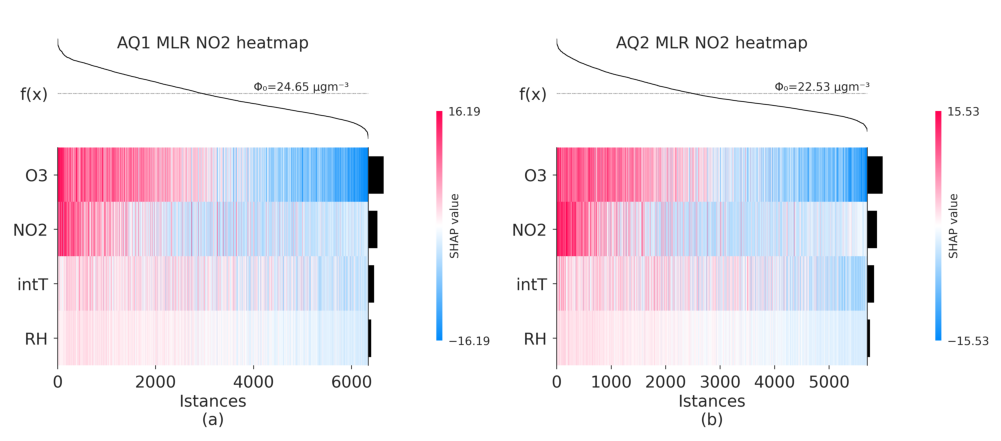

In [47]:
merge_images([f"fig07_{aq}_NO2.png"  for aq in AQS], 2, 1, "figures/fig07.png",ratio=0.5)

### SHAP MRF e MGB

In [48]:
#shap_MGB_values = pickle.load(open("shap_MGB_values.pickle", "rb"))
#del shap_MGB_values
if "shap_MGB_values" not in globals():
    shap_MGB_values = {}
    for aq in AQS:
        shap_MGB_values[aq] = {}
        X=union[aq][["aq_O3","aq_NO2","aq_intT","aq_RH"]]
        for pollutant in POLLUTANTS:
            #print(aq,param)
            y = union[aq]["horiba_%s"%pollutant]
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
            explainer = fasttreeshap.TreeExplainer(regressors["MGB"][aq][pollutant], algorithm = "v1")
            explainer.expected_value = explainer.expected_value[0] 
            shap_MGB_values[aq][pollutant] = explainer(X_test)
            shap_MGB_values[aq][pollutant].feature_names = [x.replace("aq_", "") for x in shap_MGB_values[aq][pollutant].feature_names]

    pickle.dump(shap_MGB_values, open("shap_MGB_values.pickle", "wb"))

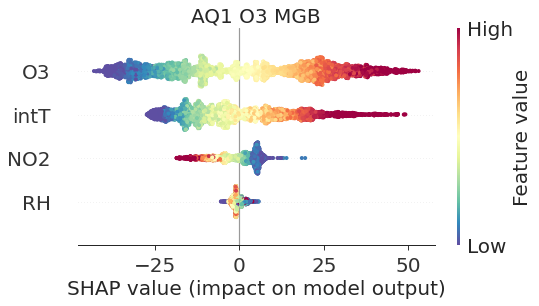

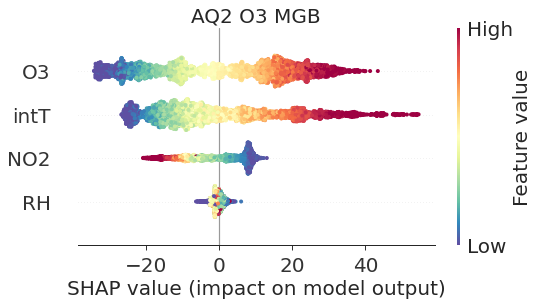

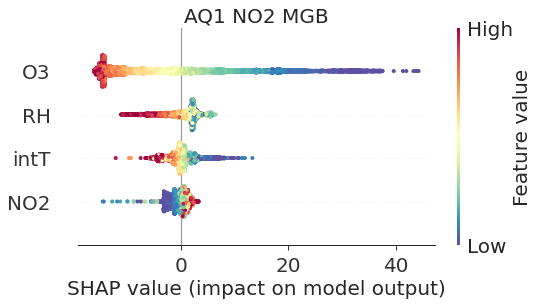

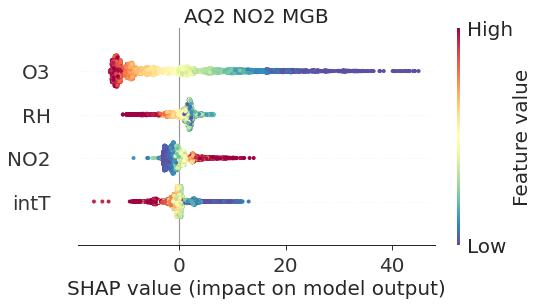

In [49]:
for pollutant in POLLUTANTS:
    for aq in AQS:
        shap.plots.beeswarm(shap_MGB_values[aq][pollutant], color=plt.get_cmap("Spectral_r"),plot_size=[8,4], show=False)
      
        fig, ax = plt.gcf(), plt.gca()

        # Modifying main plot parameters
        ax.tick_params(labelsize=size)
        ax.set_xlabel("SHAP value (impact on model output)", fontsize=size)
        # Get colorbar
        cb_ax = fig.axes[1] 
        # Modifying color bar parameters
        cb_ax.tick_params(labelsize=size)
        cb_ax.set_ylabel("Feature value", fontsize=size)        
        plt.title("%s %s MGB"%(aq, pollutant),fontsize=size)
        plt.savefig(f"supx_{aq}_{pollutant}.png", bbox_inches='tight', dpi=300)
        plt.show()        

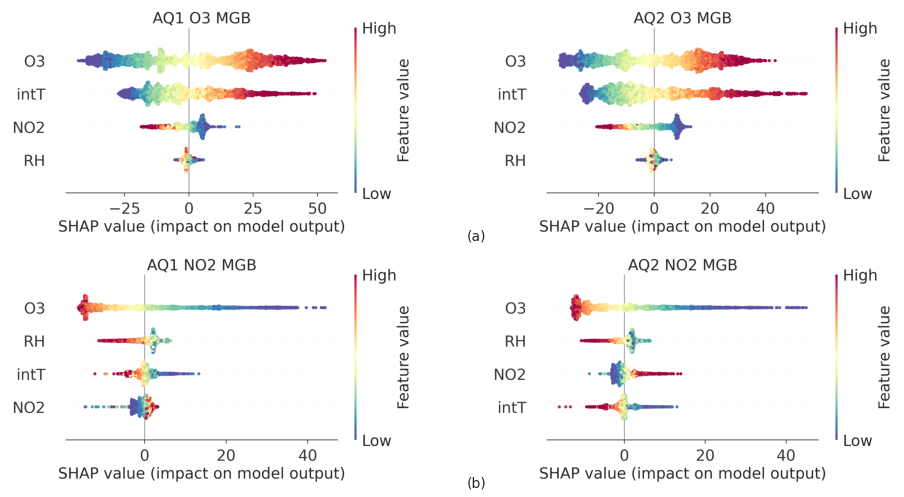

In [50]:
merge_images([f"supx_{aq}_{pollutant}.png" for aq in AQS for pollutant in POLLUTANTS], 2, 2, "figures/supx.png", FIGURES[:2], ratio=0.5)

In [51]:
#shap_MRF_values = pickle.load(open("shap_MRF_values.pickle", "rb"))
#del shap_MRF_values
if "shap_MRF_values" not in globals():
    shap_MRF_values = {}
    for aq in AQS:
        
        shap_MRF_values[aq] = {}
        X=union[aq][["aq_O3","aq_NO2","aq_intT","aq_RH"]]
        for pollutant in POLLUTANTS:
            y = union[aq]["horiba_%s"%pollutant]
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
            explainer = fasttreeshap.TreeExplainer(regressors["MRF"][aq][pollutant], algorithm = "v1")
            explainer.expected_value = explainer.expected_value[0] 
            shap_MRF_values[aq][pollutant] = explainer(X_test)
            shap_MRF_values[aq][pollutant].feature_names = [x.replace("aq_", "") for x in shap_MRF_values[aq][pollutant].feature_names]

    pickle.dump(shap_MRF_values, open("shap_MRF_values.pickle", "wb"))

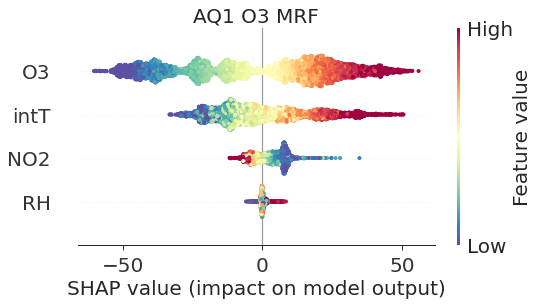

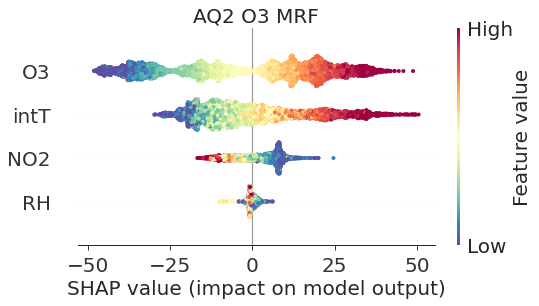

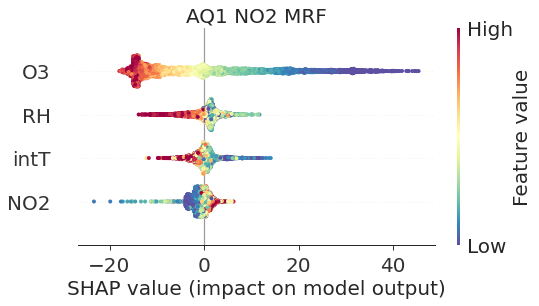

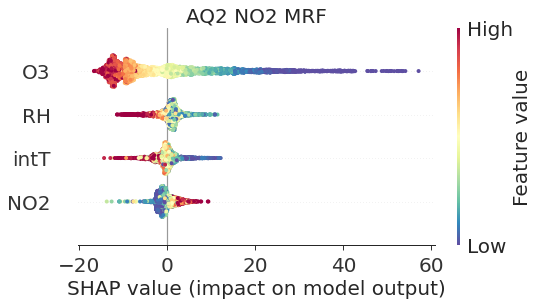

In [52]:
for pollutant in POLLUTANTS:
    for aq in AQS:
        shap.plots.beeswarm(shap_MRF_values[aq][pollutant], color=plt.get_cmap("Spectral_r"),plot_size=[8,4], show=False)
      
        fig, ax = plt.gcf(), plt.gca()

        # Modifying main plot parameters
        ax.tick_params(labelsize=size)
        ax.set_xlabel("SHAP value (impact on model output)", fontsize=size)
        # Get colorbar
        cb_ax = fig.axes[1] 
        # Modifying color bar parameters
        cb_ax.tick_params(labelsize=size)
        cb_ax.set_ylabel("Feature value", fontsize=size)        
        plt.title("%s %s MRF"%(aq, pollutant),fontsize=size)
        plt.savefig(f"fig06_{aq}_{pollutant}.png", bbox_inches='tight', dpi=300)
        plt.show()        

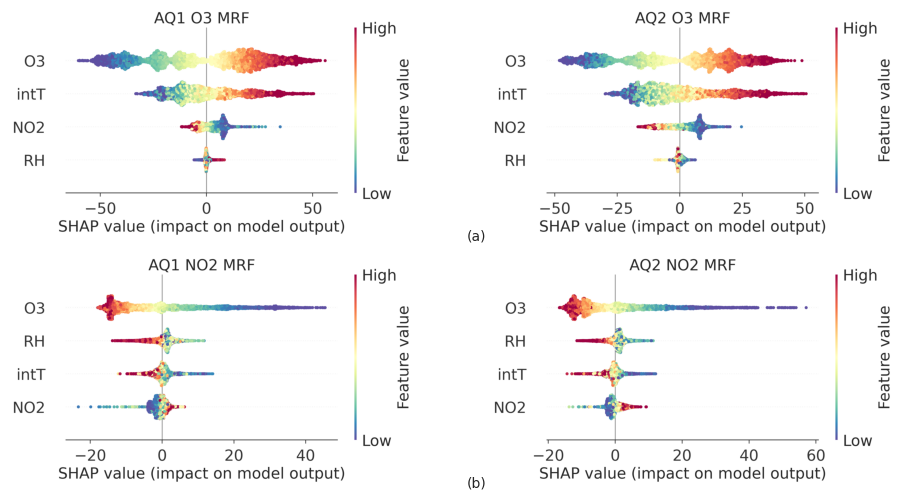

In [53]:
merge_images([f"fig06_{aq}_{pollutant}.png" for aq in AQS for pollutant in POLLUTANTS], 2, 2, "figures/fig06.png", FIGURES[:2], ratio=0.5)

### SHAP mean values for all models 

In [54]:
shap_abs_mean = pd.DataFrame()
names = [
"MLR explainer",
#"MGB explainer",
"MRF explainer"
]

for pollutant in POLLUTANTS:
    for i, shap_array in enumerate([shap_values, shap_MRF_values]):
        for aq in AQS:
            name = f"{aq} {pollutant} {names[i]}"
            for j in range(4):
                feature = shap_array[aq][pollutant].feature_names[j]
                values = shap_array[aq][pollutant].values[:,j]
                shap_abs_mean = shap_abs_mean.append({
                    "name": name,
                    "feature": feature.replace("aq_", ""),
                    "max":np.max(np.abs(values)),
                    "value": np.mean(np.abs(values)),
                    "pollutant": pollutant
                },ignore_index=True)

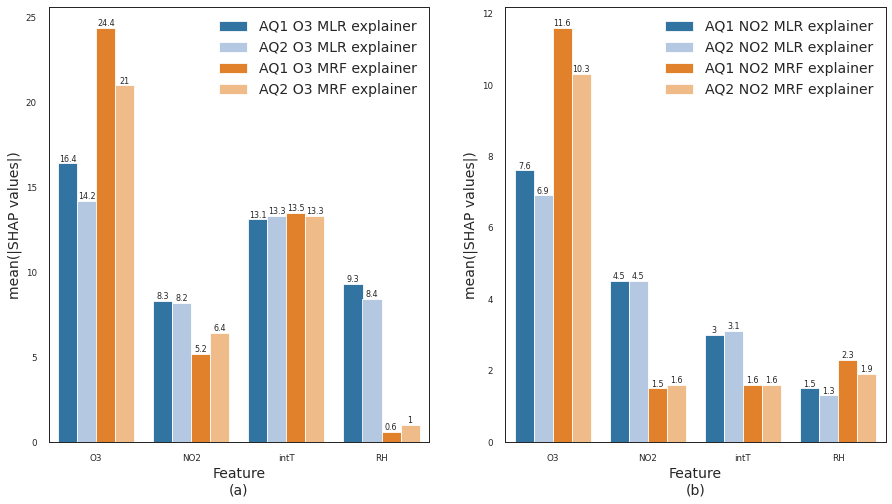

In [55]:
custom_dict = {'O3': 0, 'NO2': 1, 'intT': 3, 'RH': 4} 

fig, axs = plt.subplots(1, 2)

for i, pollutant in enumerate(POLLUTANTS):
    g = sns.barplot(
        data=shap_abs_mean[shap_abs_mean["pollutant"] == pollutant].sort_values(by=['feature'], key=lambda x: x.map(custom_dict)).round(1),
        x="feature", y="value", hue="name",
        palette="tab20", ax=axs[i]
    )
    g.set_xlabel(f"Feature\n({'ab'[i]})", fontsize=14)
    g.set_ylabel("mean(|SHAP values|)",fontsize=14)
    axs[i].get_legend().set_title("")

    for container in axs[i].containers:
        axs[i].bar_label(container, fontsize='small')
    plt.savefig("figures/sup_s04.png", bbox_inches='tight', dpi=300)
plt.show()

# Validation

In [56]:
arpat = pd.read_csv("datasets/ARPAT_IT1553A.csv", parse_dates=['date']).set_index(['date'])

In [57]:
airqino_validation = {}
for aq in AQS:
    airqino_validation[aq] = pd.read_csv(f"datasets/{aq}_montale.csv", parse_dates=['date']).set_index(['date'])

In [58]:
union_validation = {}
for aq in AQS:
    union_validation[aq] = {}
    for pollutant in POLLUTANTS:
        union_validation[aq][pollutant] = pd.merge(arpat[[f'arpat_{pollutant}']], airqino_validation[aq].resample("1H").mean(), how='inner', left_index=True, right_index=True)
        union_validation[aq][pollutant].dropna(subset=union_validation[aq][pollutant].columns.difference(['aq_extT']), inplace=True)

In [59]:
def indexToSeasonYear(name):
        x = name.month
        year = name.year
        global season
        if x in [1, 2]:
            year = int(year) - 1
        if x in [6, 7, 8]:
             season = "Summer"
        elif x in [9, 10, 11]:
             season = "Autumn"
        elif x in [12, 1, 2]:
             season = "Winter"
        elif x in [3, 4, 5]:
             season = "Spring"
        else:
             season = np.nan 
        return pd.Series([season, str(year)])

for aq in AQS:
    for pollutant in POLLUTANTS:
        for regression in ["MLR", "MRF"]:
            union_validation[aq][pollutant][f'{regression}_{pollutant}'] = regressors[regression][aq][pollutant].predict(
                union_validation[aq][pollutant][["aq_O3", "aq_NO2","aq_intT","aq_RH"]])
            union_validation[aq][pollutant][f'{regression}_{pollutant}'].clip(lower=0, inplace=True)
        union_validation[aq][pollutant]["month"] = union_validation[aq][pollutant].index.month
        union_validation[aq][pollutant]["year"] = union_validation[aq][pollutant].index.year
        union_validation[aq][pollutant][["season", "season_year"]] = union_validation[aq][pollutant].index.to_series().apply(indexToSeasonYear)


## Season analysis

In [60]:
filenames={"MLR": "tab06", "MRF": "sup_s07"}

for regression in ["MLR", "MRF"]: 
    seasony_values = pd.DataFrame()
    for aq in AQS:
        for pollutant in POLLUTANTS:
            arpat = f"arpat_{pollutant}"
            calibrated = f"{regression}_{pollutant}"
            for name, group in union_validation[aq][pollutant].groupby(by=[union_validation[aq][pollutant].season_year, union_validation[aq][pollutant].season]):

                rmse_season = mean_squared_error(group[arpat], group[calibrated], squared=False)
                seasony_values = seasony_values.append({
                        "r": group[[arpat, calibrated]].corr().iloc[0][calibrated],
                        "nRMSE": rmse_season/(group[arpat].max()-group[arpat].min())*100,
                        "MAE":mean_absolute_error(group[arpat],group[calibrated]),
                        "MBE":bias(group[calibrated],group[arpat]),
                        "date": f'{group.index.max().year}{str(group.index.max().month).zfill(2)}',
                        "year": name[0],
                        "season": name[1],
                        "param": pollutant,
                        "AQ id": aq,
                        "min-max":f'{int(group[arpat].min())} - {int(group[arpat].max())}',
                        "intT": group.aq_intT.mean(),
                    }, ignore_index=True)

                
    seasony_values = seasony_values.sort_values(by=["date", "param", "AQ id"], ascending=[True, False,True]).set_index(["year", "season", "param", "AQ id"]) #.sum(level=0)

    seasony_values = seasony_values[["min-max", "intT"] + [x for x in seasony_values.columns if x not in ["date", "min-max", "intT"]]]
    seasony_values.index = seasony_values.index.rename({"year": "Year", "season": "Season", "param": "Pollutant"})
    
    seasony_values.to_html(open(f'figures/{filenames[regression]}.html', 'w'), float_format=float_format)
    to_my_latex(seasony_values, column_groups={"": 2, "Stat.": 4}, filename=f'figures/{filenames[regression]}.tex')
    display(seasony_values)

min-max  intT    r  nRMSE   MAE   MBE
Year Season Pollutant AQ id                                       
2018 Summer O3        AQ1    6 - 166 34.65 0.94   9.17 11.69 -5.17
                      AQ2    6 - 166 34.20 0.94   8.80 11.07  7.57
            NO2       AQ1     1 - 47 34.62 0.69  35.74 14.04 13.83
                      AQ2     1 - 47 34.16 0.69  16.97  5.94  2.90
     Autumn O3        AQ1    2 - 146 28.06 0.93  13.24 15.08 11.35
                      AQ2    2 - 146 25.53 0.94  15.87 19.32 18.37
            NO2       AQ1     1 - 62 28.07 0.73  19.66  8.62  5.57
                      AQ2     1 - 62 25.54 0.71  16.57  7.60 -2.40
     Winter O3        AQ1     2 - 65 16.60 0.93  17.94  8.07  0.11
                      AQ2     2 - 72 14.53 0.93  18.97  8.97  2.50
            NO2       AQ1     3 - 88 16.59 0.71  21.01 13.97 10.44
                      AQ2     2 - 88 14.53 0.70  18.34 12.16  4.62
2019 Spring O3        AQ1    2 - 132 22.41 0.86  13.32 13.98  3.36
                      AQ2    2 - 132 21.14 0.84  13.91 14.40  4.63
            NO2       AQ1     2 - 63 22.32 0.74  13.18  6.10 -2.09
                      AQ2     2 - 63 21.09 0.67  16.19  7.31 -5.36
     Summer O3        AQ1    7 - 185 34.98 0.92  10.09 14.62 10.21
                      AQ2    7 - 185 32.29 0.92  10.68 15.98 12.71
            NO2       AQ1     0 - 47 34.94 0.63  17.82  6.36  3.58
                      AQ2     0 - 47 32.25 0.68  13.68  5.01 -3.05

min-max  intT    r  nRMSE   MAE   MBE
Year Season Pollutant AQ id                                       
2018 Summer O3        AQ1    6 - 166 34.65 0.90  10.20 12.58 -4.91
                      AQ2    6 - 166 34.20 0.84  15.59 20.68 16.52
            NO2       AQ1     1 - 47 34.62 0.64  42.26 16.00 15.87
                      AQ2     1 - 47 34.16 0.51  18.93  7.27  5.41
     Autumn O3        AQ1    2 - 146 28.06 0.84  21.49 24.43 22.53
                      AQ2    2 - 146 25.53 0.76  35.59 46.81 46.57
            NO2       AQ1     1 - 62 28.07 0.65  21.83  9.58  6.71
                      AQ2     1 - 62 25.54 0.43  18.02  8.85  1.04
     Winter O3        AQ1     2 - 65 16.60 0.88  52.57 22.13 21.12
                      AQ2     2 - 72 14.53 0.83  67.43 39.32 39.17
            NO2       AQ1     3 - 88 16.59 0.71  17.59 11.65  3.42
                      AQ2     2 - 88 14.53 0.57  20.64 13.40 -2.82
2019 Spring O3        AQ1    2 - 132 22.41 0.75  29.11 32.63 31.92
                      AQ2    2 - 132 21.14 0.68  35.91 40.38 39.57
            NO2       AQ1     2 - 63 22.32 0.67  12.73  5.67 -0.54
                      AQ2     2 - 63 21.09 0.34  17.18  8.29  2.31
     Summer O3        AQ1    7 - 185 34.98 0.82  13.42 19.44 12.35
                      AQ2    7 - 185 32.29 0.75  20.71 31.31 28.19
            NO2       AQ1     0 - 47 34.94 0.50  22.19  8.19  6.81
                      AQ2     0 - 47 32.25 0.34  18.00  7.28  5.05

## Models prefictions vs ARPAT

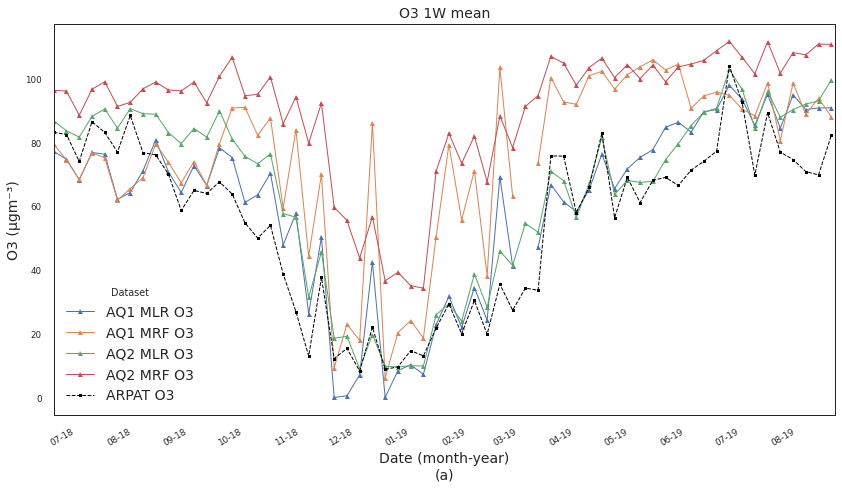

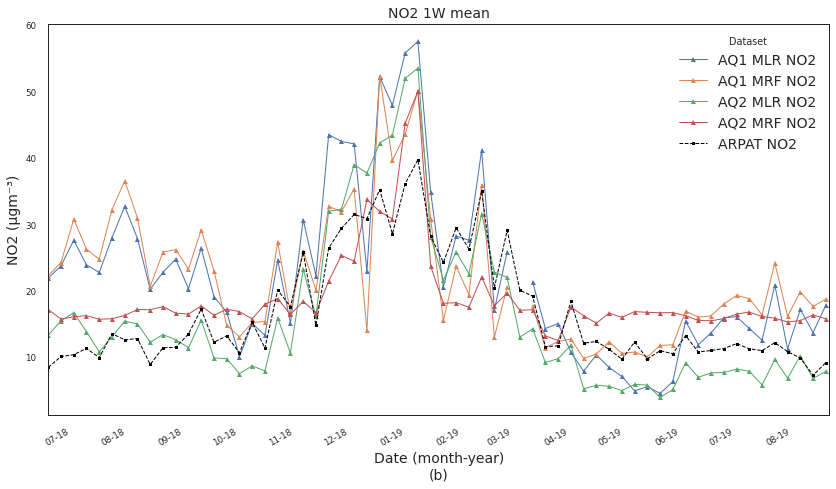

In [61]:
for i, pollutant in enumerate(POLLUTANTS):
    plt.figure(figsize=(14,8))

    ax = None
    for aq in AQS:
        for regression in ["MLR", "MRF"]:
            ax=union_validation[aq][pollutant][f"{regression}_{pollutant}"].resample("7D").mean().plot(
                label=f"{aq} {regression} {pollutant}", legend=True,style="^-",markersize=5,linewidth=1)

    union_validation[aq][pollutant][f"arpat_{pollutant}"].resample("7D").mean().plot(ax=ax,label=f"ARPAT {pollutant}", color="black", style="s--",markersize=3, linewidth=1,legend=True)
    
    a = union_validation[aq][pollutant].first_valid_index()
    b = union_validation[aq][pollutant].last_valid_index()
    
    ax.legend(title='Dataset',loc='best')
    ax.set_ylabel(f"{pollutant} (μgm⁻³)", fontsize=14)
    ax.set_xlabel(f"Date (month-year)\n({FIGURES[i]})",fontsize=14)
    ax.set_xlim([a, b])

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

    plt.gcf().autofmt_xdate()
    plt.title(f"{pollutant} 1W mean",fontsize=14)
    plt.savefig(f"sup_s07_{pollutant}.png",bbox_inches='tight', dpi=300)
    plt.show()

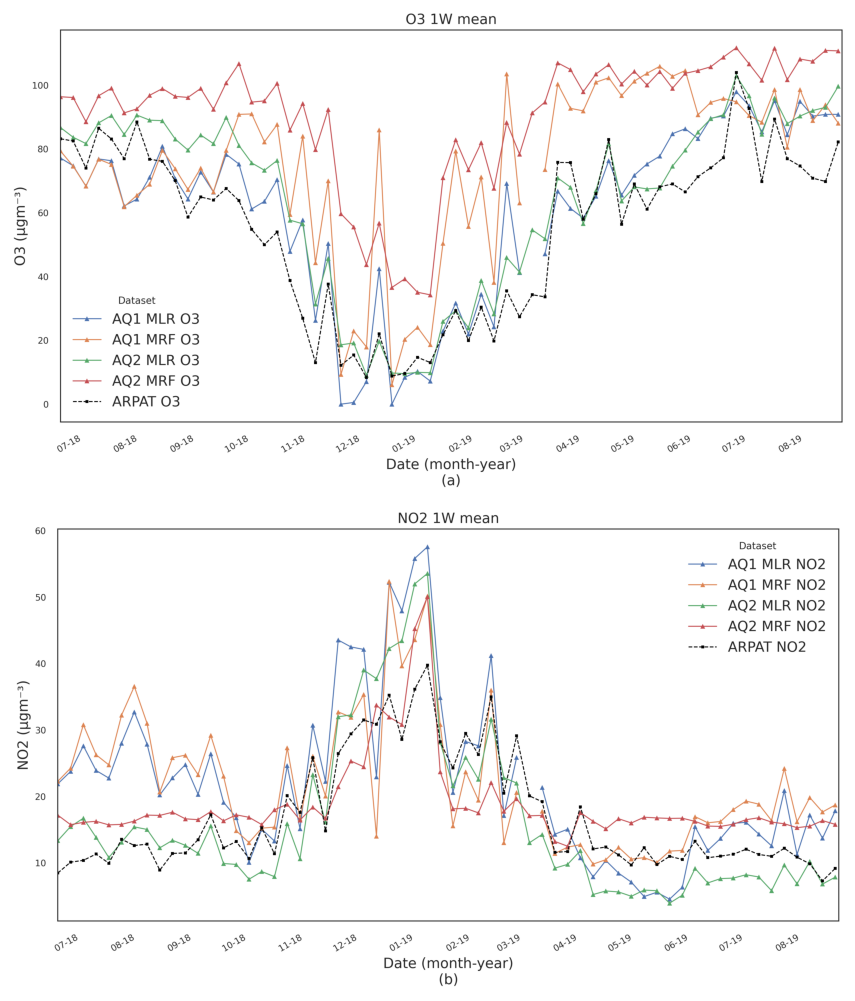

In [62]:
merge_images([f"sup_s07_{pollutant}.png" for pollutant in POLLUTANTS], 1, 2, "figures/sup_s07.png", ratio=1)

## Taylor plot

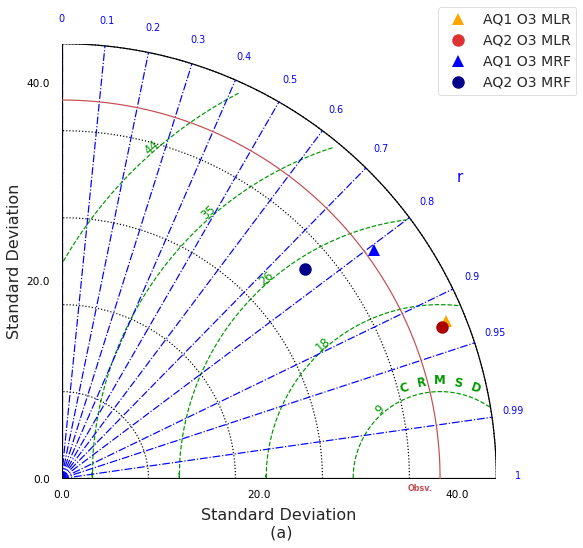

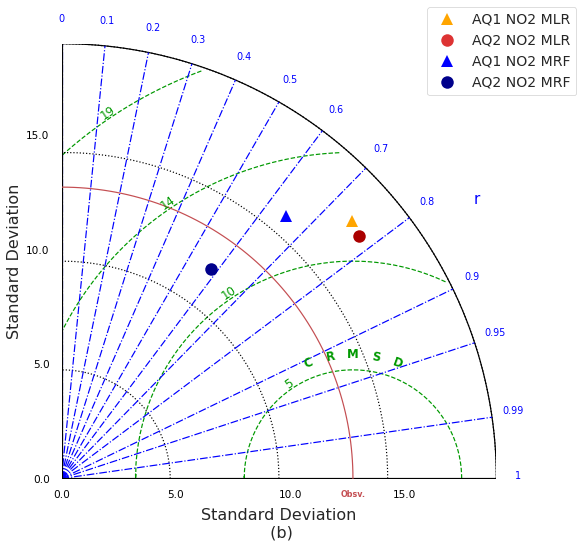

In [63]:
MARKERS  = {
    "AQ1 %s MLR": {
        "marker": "^",
        "color_edge": "#FFA500",
        "color_face": "#FFA500",
        "markersize": 25
    },
    "AQ2 %s MLR": {
        "marker": "o",
        "color_edge": "#AA0000",
        "color_face": "#DD3333",
        "markersize": 25
    },  
    "AQ1 %s MRF": {
        "marker": "^",
        "color_edge": "#0000FF",
        "color_face": "#0000FF",
        "markersize": 25
    },
    "AQ2 %s MRF": {
        "marker": "o",
        "color_edge": "#00008B",
        "color_face": "#00008B",
        "markersize": 25
    }
}


fstats = pd.DataFrame()

for j, pollutant in enumerate(POLLUTANTS):
    taylor_stats = []
    rmses = []
    for regression in ["MLR", "MRF"]:
        for aq in AQS:
            predicted = union_validation[aq][pollutant][f"{regression}_{pollutant}"]
            y_true = union_validation[aq][pollutant][f"arpat_{pollutant}"]
            taylor_stats.append(skm.taylor_statistics(predicted, y_true, "data"))
            fstats = fstats.append({"Pollutant": pollutant,
                                  "AQ id":aq,
                                  "Model": regression,
                                  "r": taylor_stats[-1]['ccoef'][1],
                                  "CRMSD": taylor_stats[-1]['crmsd'][1],
                                  "RMSE": mean_squared_error(y_true, predicted, squared=False),
                                  "MAE": mean_absolute_error(y_true, predicted),
                                  "MBE":bias(predicted, y_true)
                                  }, ignore_index=True)
            rmses.append(mean_squared_error(y_true, predicted, squared=False))

    # Store statistics in arrays
    sdev = np.array([taylor_stats[0]['sdev'][0]] + [stat['sdev'][1] for stat in taylor_stats])
    crmsd = np.array([taylor_stats[0]['crmsd'][0]]+ [stat['crmsd'][1] for stat in taylor_stats])
    ccoef = np.array([taylor_stats[0]['ccoef'][0]] + [stat['ccoef'][1] for stat in taylor_stats])

    fig, ax = plt.subplots()
    for i, k in enumerate(MARKERS):
        skm.taylor_diagram(np.array([sdev[0], sdev[i+1]]),np.array([crmsd[0], crmsd[i+1]]),np.array([ccoef[0], ccoef[i+1]]),
                           markercolors = {
                              "face": MARKERS[k]["color_edge"],
                              "edge": MARKERS[k]["color_face"]
                              },
                          markersize = MARKERS[k]["markersize"]/2,
                          markersymbol = MARKERS[k]["marker"],
                          styleOBS = '-', 
                          colOBS = 'r', markerobs = 'x', 
                          showlabelsRMS="on",
                          overlay='on' if i != 0 else 'off',
                          axisMax=round(max(sdev))+2,
                          labelRMS="CRMSD",
                          rmsLabelFormat="0:.0f",
                          titleRMSDangle=90,
                          titleSTD = 'off',
                          titleCOR = 'off',
                          titleOBS = 'off',
                          )
    # add label below the marker
    ax.text(sdev[0]-(2 if j == 0 else 0), -0.5 if j == 0 else -0.5, "Obsv.", verticalalignment="top",
            horizontalalignment="center",  color= "r",
            fontsize=8, fontweight="bold")
        
    legend_handles = []

    for marker_label, marker_desc in MARKERS.items():
        marker = mlines.Line2D([], [], 
                               marker=marker_desc["marker"],
                               markersize=marker_desc["markersize"]/2,
                               markerfacecolor=marker_desc["color_face"],
                               markeredgecolor=marker_desc["color_edge"],
                               linestyle='None',
                               label=marker_label%pollutant
                              )
        
        legend_handles.append(marker)
        del marker_label, marker_desc, marker

    # create legend and free memory
    ax.legend(handles=legend_handles, loc="upper right", bbox_to_anchor=(1, 1, 0.2, 0.1),fontsize=14,frameon=True)
    ax.set_xlabel('',fontsize=14)
    ax.set_title('Standard Deviation\n (%s)'%FIGURES[j], y=-0.15,fontsize=16)
    ax.set_ylabel('Standard Deviation',fontsize=16)
    if j == 0:
        ax.text(40, 30, 'r', fontsize=15, color='blue')
    else:
        ax.text(18, 12, 'r', fontsize=15, color='blue')
    plt.savefig(f"fig08_{pollutant}.png", bbox_inches='tight', dpi=300)
    plt.show()
fstats = fstats.set_index(["Pollutant", "Model","AQ id"]).sort_values(by=["Pollutant", "Model"], ascending=[False, True])

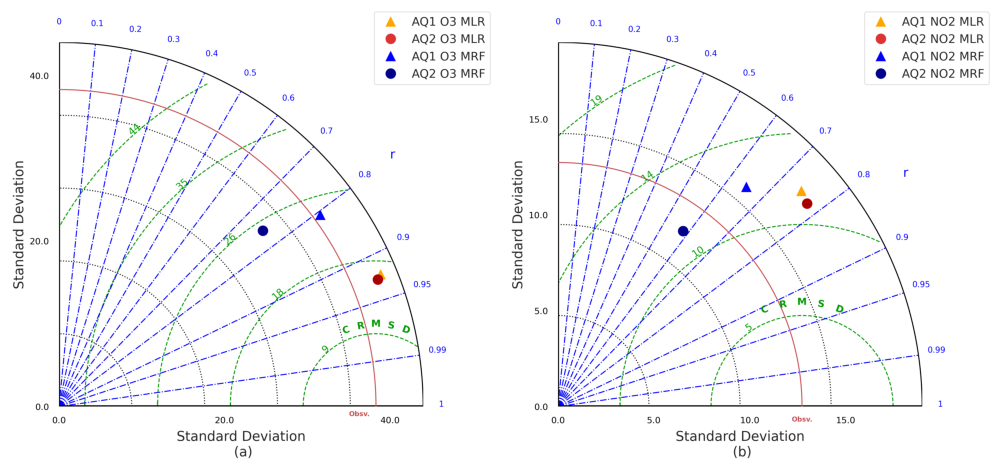

In [64]:
merge_images([f"fig08_{pollutant}.png" for pollutant in POLLUTANTS], 2, 1, "figures/fig08.png")

In [65]:
tmp=fstats.reset_index()
tmp = tmp[["AQ id", "Pollutant", "Model", "r", "CRMSD", "RMSE","MAE","MBE"]].melt(
    id_vars=["AQ id", "Pollutant", "Model"], var_name="Stat.", value_name="Multiple model", ignore_index=False).pivot_table(
    columns=["Model"], values=["Multiple model"], index=["Pollutant", "AQ id", "Stat."], sort=False)
tmp.index = tmp.index.rename(["Pollutant", "AQ id","Stat."])
tmp

Multiple model      
Model                            MLR   MRF
Pollutant AQ id Stat.                     
O3        AQ1   r               0.92  0.81
                CRMSD          15.98 24.13
                RMSE           16.52 29.08
                MAE            12.96 22.22
                MBE             4.20 16.23
          AQ2   r               0.93  0.76
                CRMSD          15.35 25.44
                RMSE           17.88 42.98
                MAE            13.99 36.24
                MBE             9.17 34.64
NO2       AQ1   r               0.75  0.65
                CRMSD          11.25 11.83
                RMSE           12.64 13.48
                MAE             9.40  9.97
                MBE             5.75  6.46
          AQ2   r               0.78  0.58
                CRMSD          10.63 11.77
                RMSE           10.65 11.94
                MAE             7.72  9.12
                MBE            -0.69  2.03

In [66]:
tmp.to_html(open('figures/sup_s05.html', 'w'), float_format=float_format)
to_my_latex(tmp, filename='figures/sup_s05.tex')